# Microstate stats and their analysis

Analysis of microstate stats such as average lifespan, coverage, frequency of occurrence, and transition probabilities.

In [1]:
%matplotlib inline

import os
import string

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
from IPython.display import display

from src.helpers import PLOTS_ROOT, RESULTS_ROOT, make_dirs

plt.style.use("default")
plt.rcParams["legend.frameon"] = False
plt.rcParams["figure.figsize"] = (20, 9)
sns.set_context("notebook", font_scale=2)

WORKING_DIR = os.path.join(RESULTS_ROOT, "20260116-new-recompute")
PLOTTING_DIR = os.path.join(PLOTS_ROOT, "new")
if not os.path.exists(PLOTTING_DIR):
    make_dirs(PLOTTING_DIR)

# if True, will save all statistical tests as csv and all plots as eps
SAVE_RESULTS = True
PLOT_EXT = ".eps"
# which correction for multiple comparisons should be used
MULTI_CORRECTION = "fdr_bh"
P_THRESH = 0.05

In [2]:
# load data computed with `1-main_gfp_stats_and_ideal_no_mstates.py`
df = pd.read_csv(os.path.join(WORKING_DIR, "ms_stats.csv"), index_col=[0])
# divide session into PLA/PSI and time for plotting purposes
df[["condition", "time"]] = df["session"].str.split("-", expand=True)
# divide to filters
df_220 = df[df["ms_opts"] == "(2.0, 20.0, 4)"]
df_220 = df_220.sort_values(by=["condition", "time"])
df_140 = df[df["ms_opts"] == "(1.0, 40.0, 3)"]
df_140 = df_140.sort_values(by=["condition", "time"])

In [3]:
# Functions for computing, saving and displaying ANOVAs and posthoc tests


def diff_between_microstates(df, dv, filt_str):
    df = df.copy()
    print("==========")
    print(f"Microstate differences: {dv}")
    print("==========")
    anova = pg.anova(data=df, dv=dv, between=["microstate"], detailed=False)
    if SAVE_RESULTS:
        anova.round(5).to_csv(
            os.path.join(
                WORKING_DIR, f"{dv}_{filt_str}filt_microstate_anova.csv"
            )
        )
    print("ANOVA")
    display(anova)
    posthoc = pg.pairwise_tukey(
        data=df, dv=dv, between="microstate", effsize="cohen"
    )
    if SAVE_RESULTS:
        posthoc.round(5).to_csv(
            os.path.join(
                WORKING_DIR, f"{dv}_{filt_str}filt_microstate_posthoc.csv"
            )
        )
    print("Tukey HSD")
    display(posthoc)

    print("==========")
    print(f"Microstate differences w.r.t condition: {dv}")
    print("==========")
    posthoc = pg.pairwise_tests(
        data=df,
        dv=dv,
        between=["microstate"],
        within=["condition"],
        padjust=MULTI_CORRECTION,
        effsize="cohen",
        subject="subject",
        within_first=False,
    )
    display(posthoc[posthoc["p-corr"] <= P_THRESH])


def diff_between_time(df, dv, filt_str):
    df = df.copy()
    print("==========")
    print(f"Time differences: {dv}")
    print("==========")
    anova = pg.rm_anova(
        data=df, dv=dv, within=["time", "condition"], subject="subject"
    )
    if SAVE_RESULTS:
        anova.round(5).to_csv(
            os.path.join(WORKING_DIR, f"{dv}_{filt_str}filt_time_anova.csv")
        )
    print("RM ANOVA")
    display(anova)

    posthoc = pg.pairwise_tests(
        data=df,
        dv=dv,
        within=["time", "condition"],
        subject="subject",
        effsize="cohen",
        padjust=MULTI_CORRECTION,
        return_desc=True,
    )
    if SAVE_RESULTS:
        posthoc.round(5).to_csv(
            os.path.join(
                WORKING_DIR, f"{dv}_{filt_str}filt_time_cond_posthoc.csv"
            )
        )
    print(
        f"Pairwise 'time x condition' t-tests (showing only significant after {MULTI_CORRECTION.upper()} correction < 0.05)"
    )
    display(posthoc[posthoc["p-corr"] <= P_THRESH])

    posthoc = pg.pairwise_tests(
        data=df,
        dv=dv,
        within=["condition", "time"],
        subject="subject",
        effsize="cohen",
        padjust=MULTI_CORRECTION,
        return_desc=True,
    )
    if SAVE_RESULTS:
        posthoc.round(5).to_csv(
            os.path.join(
                WORKING_DIR, f"{dv}_{filt_str}filt_cond_time_posthoc.csv"
            )
        )
    print(
        f"Pairwise 'condition x time' t-tests (showing only significant after {MULTI_CORRECTION.upper()} correction < 0.05)"
    )
    display(posthoc[posthoc["p-corr"] <= P_THRESH])


def diff_between_time_and_microstates(df, dv, filt_str):
    df = df.copy()
    print("==========")
    print(f"Time differences: {dv}")
    print("==========")
    for ms in np.unique(df["microstate"]):
        print("----------")
        print(f"microstate {ms}")
        print("----------")
        anova = pg.rm_anova(
            data=df[df["microstate"] == ms],
            dv=dv,
            within=["time", "condition"],
            subject="subject",
        )
        if SAVE_RESULTS:
            anova.round(5).to_csv(
                os.path.join(
                    WORKING_DIR, f"{dv}_microstate{ms}_{filt_str}filt_anova.csv"
                )
            )
        print("RM ANOVA")
        display(anova)

        posthoc = pg.pairwise_tests(
            data=df[df["microstate"] == ms],
            dv=dv,
            within=["time", "condition"],
            subject="subject",
            effsize="cohen",
            padjust=MULTI_CORRECTION,
            return_desc=True,
        )
        if SAVE_RESULTS:
            posthoc.round(5).to_csv(
                os.path.join(
                    WORKING_DIR,
                    f"{dv}_microstate{ms}_{filt_str}filt_time_cond_posthoc.csv",
                )
            )
        print(
            f"Pairwise 'time x condition' t-tests (showing only significant after {MULTI_CORRECTION.upper()} correction < 0.05)"
        )
        display(posthoc[posthoc["p-corr"] <= P_THRESH])

        posthoc = pg.pairwise_tests(
            data=df[df["microstate"] == ms],
            dv=dv,
            within=["condition", "time"],
            subject="subject",
            effsize="cohen",
            padjust=MULTI_CORRECTION,
            return_desc=True,
        )
        if SAVE_RESULTS:
            posthoc.round(5).to_csv(
                os.path.join(
                    WORKING_DIR,
                    f"{dv}_microstate{ms}_{filt_str}filt_cond_time_posthoc.csv",
                )
            )
        print(
            f"Pairwise 'condition x time' t-tests (showing only significant after {MULTI_CORRECTION.upper()} correction < 0.05)"
        )
        display(posthoc[posthoc["p-corr"] <= P_THRESH])

In [4]:
## Functions for plotting and saving boxplots


def _plot_ttest_signi(
    where, df_for_max, ax, plot_for="time", x1_base=-0.2, x2_base=0.2
):
    y = df_for_max.max() * 1.02
    h = df_for_max.max() * 0.05
    col = plt.rcParams["text.color"]
    for _, row in where.iterrows():
        if plot_for == "time":
            pos = int(row["time"][-1]) - 1
        elif plot_for == "microstate":
            pos = string.ascii_uppercase.index(row["microstate"])
        else:
            raise ValueError(f"Unkown for: {plot_for}")
        x1, x2 = x1_base + pos, x2_base + pos
        ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
        if row["p-corr"] < 0.001:
            text = "p < 0.000"
        else:
            text = f"p={row['p-corr']:.3f}"
        ax.text(
            (x1 + x2) * 0.5,
            y + h,
            text,
            ha="center",
            va="bottom",
            color=col,
            fontsize=18,
        )


def plot_boxes(df, dv, filt_str, legend_pos, plot_signi=True):
    # individual "factors"
    _, axs = plt.subplots(1, 2, sharey=True, sharex=False)
    sns.boxplot(
        x="microstate",
        y=dv,
        data=df.copy(),
        hue="condition",
        ax=axs[0],
        legend=legend_pos == 1,
    )
    sns.despine(trim=True, ax=axs[0])
    if plot_signi:
        sign = pg.pairwise_tests(
            data=df,
            dv=dv,
            between=["microstate"],
            within=["condition"],
            padjust=MULTI_CORRECTION,
            subject="subject",
            within_first=False,
        )
        # find significant
        where = sign[
            (sign["p-corr"] <= 0.05)
            & (sign["Contrast"] == "microstate * condition")
        ]
        _plot_ttest_signi(
            where,
            df[dv],
            ax=axs[0],
            plot_for="microstate",
            x1_base=-0.2,
            x2_base=0.2,
        )

    sns.boxplot(
        x="time",
        y=dv,
        data=df.copy(),
        hue="condition",
        ax=axs[1],
        legend=legend_pos == 2,
    )
    sns.despine(trim=True, ax=axs[1])
    if plot_signi:
        sign = pg.pairwise_tests(
            data=df,
            dv=dv,
            within=["time", "condition"],
            subject="subject",
            padjust=MULTI_CORRECTION,
        )
        # find significant
        where = sign[
            (sign["p-corr"] <= 0.05) & (sign["Contrast"] == "time * condition")
        ]
        _plot_ttest_signi(
            where, df[dv], ax=axs[1], plot_for="time", x1_base=-0.2, x2_base=0.2
        )

    if SAVE_RESULTS:
        plt.savefig(
            os.path.join(
                PLOTTING_DIR, f"{dv}_boxplot_factors_{filt_str}filt{PLOT_EXT}"
            ),
            bbox_inches="tight",
            transparent=True,
        )
    else:
        plt.show()

    # interaction
    _, axs = plt.subplots(
        1, len(np.unique(df["microstate"])), sharex=True, sharey=True
    )
    for i, ms in enumerate(np.unique(df["microstate"])):
        ax = axs[i]
        sns.boxplot(
            x="time",
            y=dv,
            data=df[df["microstate"] == ms],
            hue="condition",
            ax=ax,
            legend=legend_pos > 2,
        )
        ax.set_title(f"Microstate {ms}")
        sns.despine(trim=True, ax=ax)
        if plot_signi:
            sign = pg.pairwise_tests(
                data=df[df["microstate"] == ms],
                dv=dv,
                within=["time", "condition"],
                subject="subject",
                padjust=MULTI_CORRECTION,
            )
            # find significant
            where = sign[
                (sign["p-corr"] <= 0.05)
                & (sign["Contrast"] == "time * condition")
            ]
            _plot_ttest_signi(
                where,
                df[df["microstate"] == ms][dv],
                ax=ax,
                plot_for="time",
                x1_base=-0.2,
                x2_base=0.2,
            )
        plt.tight_layout()
    if SAVE_RESULTS:
        plt.savefig(
            os.path.join(
                PLOTTING_DIR,
                f"{dv}_boxplot_interaction_{filt_str}filt{PLOT_EXT}",
            ),
            bbox_inches="tight",
            transparent=True,
        )
    else:
        plt.show()

## Explained variance

In [5]:
# 2-20Hz
pg.rm_anova(
    data=df_220.drop_duplicates(subset=["subject", "session"]),
    dv="var_GFP",
    within=["condition", "time"],
    subject="subject",
)

/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,condition,0.014491,1,14,0.014491,4.170104,0.060452,0.060452,0.027284,1.000000
1,time,0.008729,4,56,0.002182,2.064479,0.097706,0.123474,0.016616,0.708580
2,condition * time,0.011943,4,56,0.002986,1.974560,0.110919,0.143689,0.022595,0.634549


In [6]:
# 1-40Hz
pg.rm_anova(
    data=df_140.drop_duplicates(subset=["subject", "session"]),
    dv="var_GFP",
    within=["condition", "time"],
    subject="subject",
)

/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,condition,0.023335,1,14,0.023335,5.681119,0.031859,0.031859,0.032804,1.000000
1,time,0.012965,4,56,0.003241,2.557269,0.048550,0.070618,0.018496,0.721340
2,condition * time,0.020416,4,56,0.005104,2.708917,0.039129,0.068648,0.028819,0.630921


## Average lifespan ~ 2-20Hz filter ~ 4 microstates

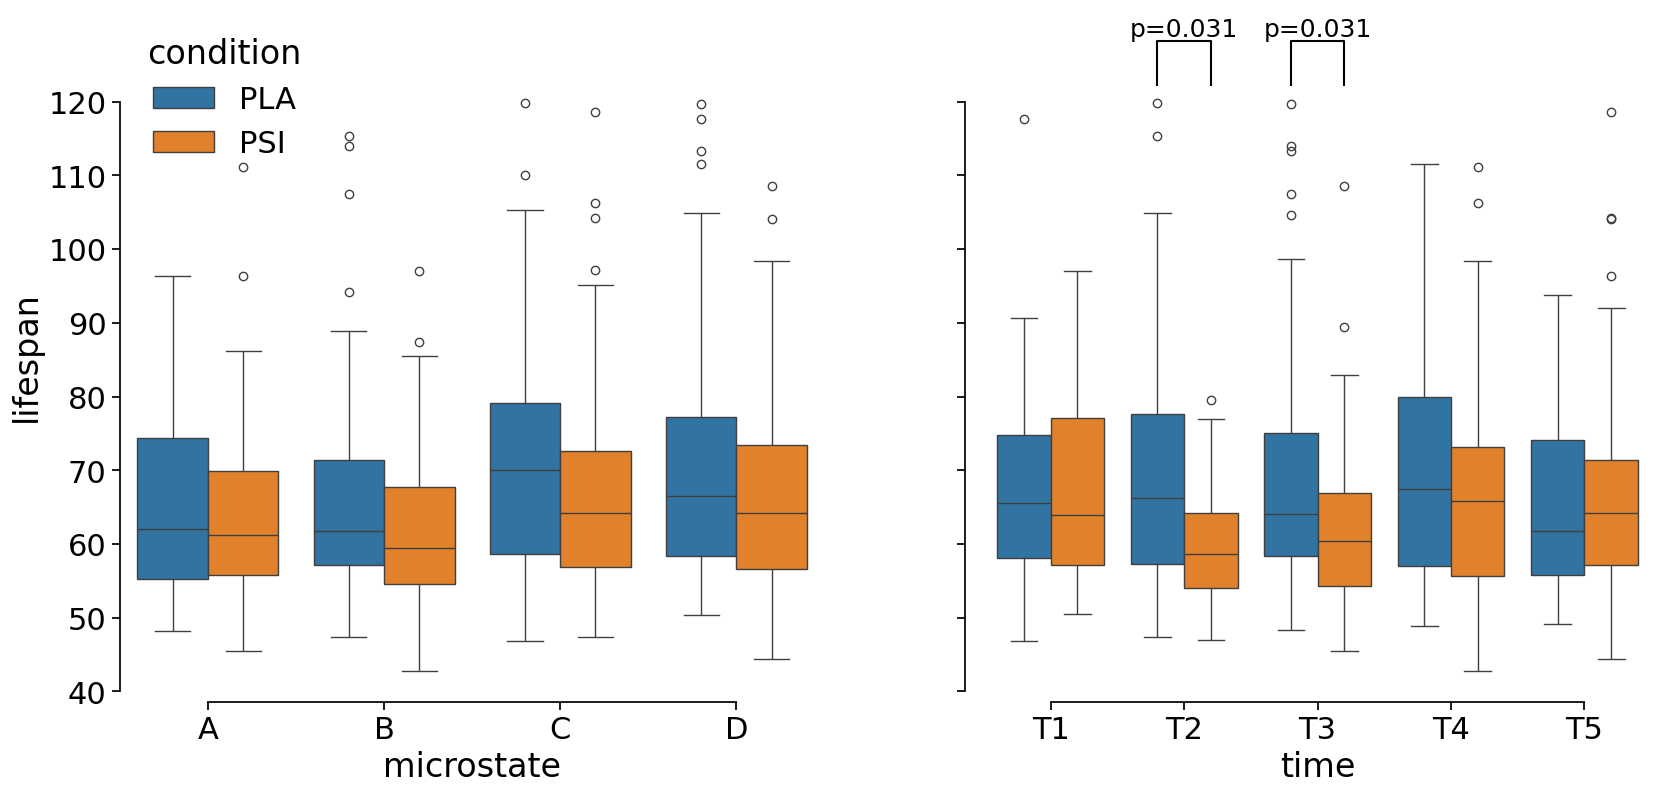

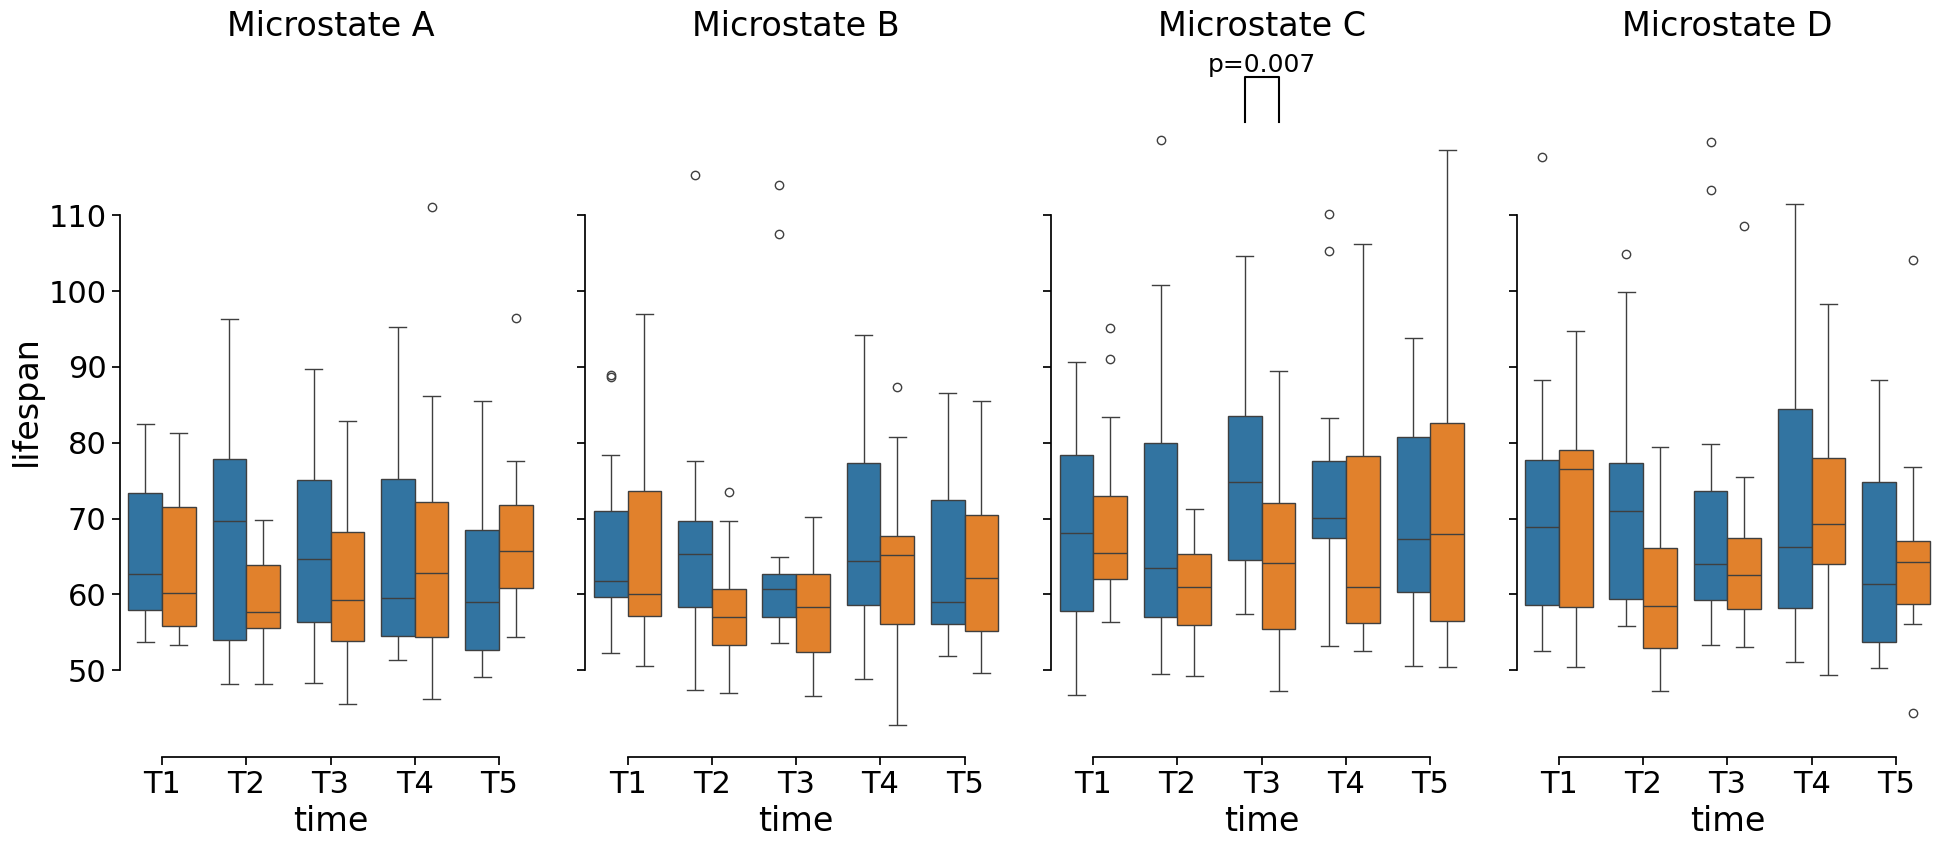

In [7]:
plot_boxes(df_220, "lifespan", "2-20", 1, plot_signi=True)

### Differences between microstates

In [8]:
diff_between_microstates(df_220, "lifespan", filt_str="2-20")

Microstate differences: lifespan
ANOVA


,Source,ddof1,ddof2,F,p-unc,np2
0,microstate,3,596,6.399196,0.000285,0.031206


Tukey HSD


,A,B,mean(A),mean(B),diff,se,T,p-tukey,cohen
0,A,B,64.225940,64.092724,0.133217,1.567445,0.084990,0.999780,0.010961
1,A,C,64.225940,69.562002,-5.336061,1.567445,-3.404305,0.003939,-0.395237
2,A,D,64.225940,68.302594,-4.076653,1.567445,-2.600827,0.046859,-0.304761
3,B,C,64.092724,69.562002,-5.469278,1.567445,-3.489294,0.002917,-0.397201
4,B,D,64.092724,68.302594,-4.209870,1.567445,-2.685816,0.037238,-0.308469
5,C,D,69.562002,68.302594,1.259408,1.567445,0.803478,0.852798,0.084752


Microstate differences w.r.t condition: lifespan


,Contrast,microstate,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen


### Differences between times

In [9]:
diff_between_time(df_220, "lifespan", filt_str="2-20")

Time differences: lifespan
RM ANOVA


/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,time,286.062812,4,56,71.515703,3.871026,0.007595,0.015783,0.019209,0.747284
1,condition,510.215923,1,14,510.215923,5.069068,0.040941,0.040941,0.033753,1.000000
2,time * condition,695.683053,4,56,173.920763,4.561560,0.002931,0.010062,0.045465,0.670268


Pairwise 'time x condition' t-tests (showing only significant after FDR_BH correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen
0,time,-,T1,T2,67.510257,7.614015,64.323376,7.585300,True,True,3.727060,14.0,two-sided,0.002253,0.022533,fdr_bh,19.355,0.419345
12,time * condition,T2,PLA,PSI,69.115093,12.917077,59.531658,5.125831,True,True,2.970717,14.0,two-sided,0.010122,0.031268,fdr_bh,5.515,0.975252
13,time * condition,T3,PLA,PSI,70.071146,12.751235,62.471870,6.928073,True,True,2.863704,14.0,two-sided,0.012507,0.031268,fdr_bh,4.637,0.740570


Pairwise 'condition x time' t-tests (showing only significant after FDR_BH correction < 0.05)


,Contrast,condition,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen
1,time,-,T1,T2,67.510257,7.614015,64.323376,7.585300,True,True,3.727060,14.0,two-sided,0.002253,0.022533,fdr_bh,19.355,0.419345
19,condition * time,PLA,T3,T5,70.071146,12.751235,65.226225,9.199485,True,True,3.450051,14.0,two-sided,0.003904,0.039043,fdr_bh,12.172,0.435769
20,condition * time,PLA,T4,T5,69.728962,11.763814,65.226225,9.199485,True,True,3.236528,14.0,two-sided,0.005971,0.039804,fdr_bh,8.534,0.426405
21,condition * time,PSI,T1,T2,67.211369,9.601831,59.531658,5.125831,True,True,3.619602,14.0,two-sided,0.002788,0.039043,fdr_bh,16.164,0.997831
22,condition * time,PSI,T1,T3,67.211369,9.601831,62.471870,6.928073,True,True,2.730947,14.0,two-sided,0.016241,0.046403,fdr_bh,3.749,0.566088
26,condition * time,PSI,T2,T4,59.531658,5.125831,67.093526,11.581784,True,True,-2.806385,14.0,two-sided,0.014003,0.046403,fdr_bh,4.229,-0.844356
27,condition * time,PSI,T2,T5,59.531658,5.125831,67.199155,10.745499,True,True,-2.826886,14.0,two-sided,0.013449,0.046403,fdr_bh,4.37,-0.910799
28,condition * time,PSI,T3,T4,62.471870,6.928073,67.093526,11.581784,True,True,-2.752033,14.0,two-sided,0.015583,0.046403,fdr_bh,3.877,-0.484300


### Significance of time / condition for each microstate

In [10]:
diff_between_time_and_microstates(df_220, "lifespan", filt_str="2-20")

Time differences: lifespan
----------
microstate A
----------
RM ANOVA


/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,time,119.570319,4,56,29.892580,0.483423,0.747784,0.633426,0.005987,0.533285
1,condition,93.488631,1,14,93.488631,0.972384,0.340823,0.340823,0.004687,1.000000
2,time * condition,853.382923,4,56,213.345731,2.481742,0.054056,0.066545,0.041216,0.834257


Pairwise 'time x condition' t-tests (showing only significant after FDR_BH correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen


Pairwise 'condition x time' t-tests (showing only significant after FDR_BH correction < 0.05)


,Contrast,condition,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen


----------
microstate B
----------
RM ANOVA


/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,time,358.113353,4,56,89.528338,1.536873,0.204038,0.219570,0.016331,0.740497
1,condition,742.943486,1,14,742.943486,3.978781,0.065923,0.065923,0.033295,1.000000
2,time * condition,429.261175,4,56,107.315294,1.519147,0.209054,0.218216,0.019512,0.841809


Pairwise 'time x condition' t-tests (showing only significant after FDR_BH correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen


Pairwise 'condition x time' t-tests (showing only significant after FDR_BH correction < 0.05)


,Contrast,condition,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen


----------
microstate C
----------
RM ANOVA


/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,time,716.430619,4,56,179.107655,2.203927,0.080207,0.092221,0.022859,0.852908
1,condition,862.952364,1,14,862.952364,2.929152,0.109047,0.109047,0.027406,1.000000
2,time * condition,1195.687252,4,56,298.921813,2.991451,0.026191,0.042180,0.037576,0.741690


Pairwise 'time x condition' t-tests (showing only significant after FDR_BH correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen
13,time * condition,T3,PLA,PSI,75.96054,14.957378,64.544146,11.672507,True,True,3.937322,14.0,two-sided,0.001488,0.007442,fdr_bh,27.542,0.850963


Pairwise 'condition x time' t-tests (showing only significant after FDR_BH correction < 0.05)


,Contrast,condition,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen


----------
microstate D
----------
RM ANOVA


/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,time,702.243369,4,56,175.560842,1.848047,0.132493,0.145447,0.022557,0.839347
1,condition,578.395108,1,14,578.395108,1.928875,0.186581,0.186581,0.018653,1.000000
2,time * condition,692.688891,4,56,173.172223,1.121010,0.355862,0.352086,0.022257,0.775831


Pairwise 'time x condition' t-tests (showing only significant after FDR_BH correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen


Pairwise 'condition x time' t-tests (showing only significant after FDR_BH correction < 0.05)


,Contrast,condition,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen


## Coverage ~ 2-20Hz filter ~ 4 microstates

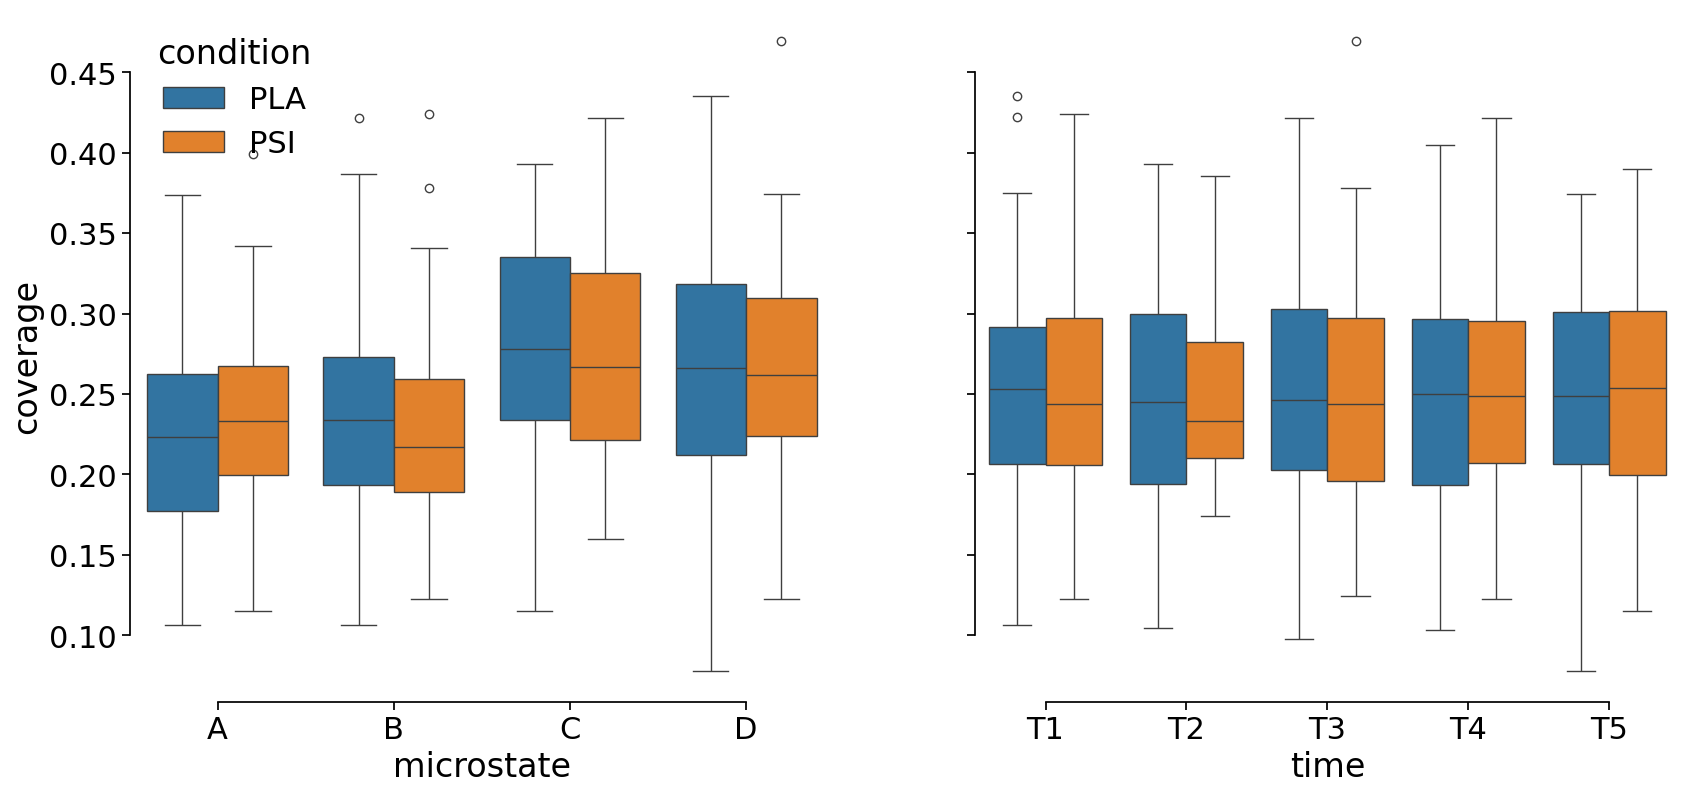

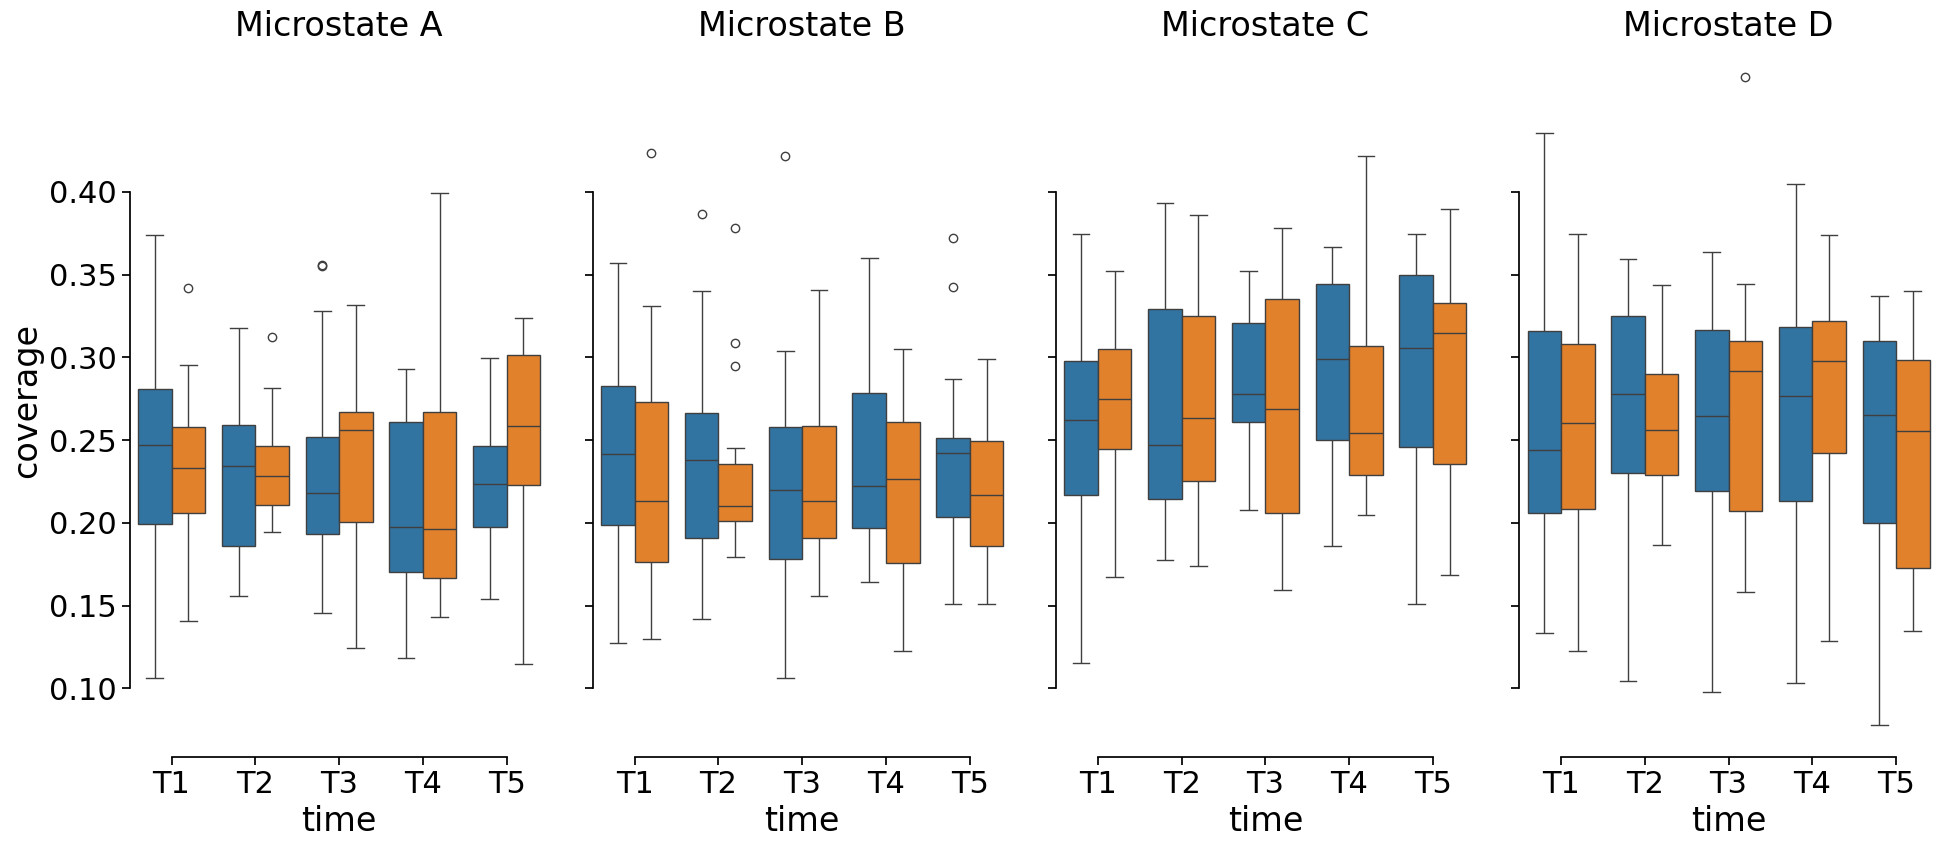

In [11]:
plot_boxes(df_220, "coverage", "2-20", 1)

### Differences between microstates

In [12]:
diff_between_microstates(df_220, "coverage", filt_str="2-20")

Microstate differences: coverage
ANOVA


,Source,ddof1,ddof2,F,p-unc,np2
0,microstate,3,596,19.575987,4.082565e-12,0.089698


Tukey HSD


,A,B,mean(A),mean(B),diff,se,T,p-tukey,cohen
0,A,B,0.230408,0.231039,-0.000631,0.007332,-0.086034,9.997716e-01,-0.010819
1,A,C,0.230408,0.276060,-0.045652,0.007332,-6.226441,5.401134e-09,-0.755815
2,A,D,0.230408,0.262492,-0.032083,0.007332,-4.375857,8.405542e-05,-0.497543
3,B,C,0.231039,0.276060,-0.045021,0.007332,-6.140406,9.014219e-09,-0.720413
4,B,D,0.231039,0.262492,-0.031453,0.007332,-4.289823,1.224561e-04,-0.473344
5,C,D,0.276060,0.262492,0.013568,0.007332,1.850583,2.508070e-01,0.198673


Microstate differences w.r.t condition: coverage


,Contrast,microstate,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen
1,microstate,-,A,C,False,True,-6.226330,28.0,two-sided,9.975542e-07,0.000006,fdr_bh,1.189e+04,-2.273534
2,microstate,-,A,D,False,True,-2.719735,28.0,two-sided,1.109561e-02,0.022191,fdr_bh,4.706,-0.993107
3,microstate,-,B,C,False,True,-4.256355,28.0,two-sided,2.105838e-04,0.000632,fdr_bh,111.784,-1.554201
4,microstate,-,B,D,False,True,-2.239319,28.0,two-sided,3.326020e-02,0.049890,fdr_bh,2.116,-0.817684


### Differences between time

In [13]:
diff_between_time(df_220, "coverage", filt_str="2-20")

Time differences: coverage
RM ANOVA


/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,time,1.155558e-31,4,56,2.888895e-32,-4.751131,1.0,1.0,0.576923,0.805820
1,condition,4.622232e-31,1,14,4.622232e-31,-12.727273,1.0,1.0,0.845070,1.000000
2,time * condition,-4.622232e-31,4,56,-1.155558e-31,-12.883436,1.0,1.0,1.224490,0.784419


Pairwise 'time x condition' t-tests (showing only significant after FDR_BH correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen


Pairwise 'condition x time' t-tests (showing only significant after FDR_BH correction < 0.05)


,Contrast,condition,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen


### Significance of time / condition for each microstate

In [14]:
diff_between_time_and_microstates(df_220, "coverage", filt_str="2-20")

Time differences: coverage
----------
microstate A
----------
RM ANOVA


/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,time,0.009651,4,56,0.002413,0.935898,0.449937,0.429550,0.021004,0.724022
1,condition,0.004214,1,14,0.004214,1.048542,0.323212,0.323212,0.009281,1.000000
2,time * condition,0.004500,4,56,0.001125,0.309617,0.870366,0.834635,0.009904,0.817819


Pairwise 'time x condition' t-tests (showing only significant after FDR_BH correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen


Pairwise 'condition x time' t-tests (showing only significant after FDR_BH correction < 0.05)


,Contrast,condition,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen


----------
microstate B
----------
RM ANOVA


/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,time,0.003086,4,56,0.000771,0.313552,0.867741,0.794017,0.005725,0.672011
1,condition,0.003577,1,14,0.003577,0.766324,0.396128,0.396128,0.006630,1.000000
2,time * condition,0.002278,4,56,0.000570,0.193314,0.940905,0.878733,0.004233,0.659899


Pairwise 'time x condition' t-tests (showing only significant after FDR_BH correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen


Pairwise 'condition x time' t-tests (showing only significant after FDR_BH correction < 0.05)


,Contrast,condition,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen


----------
microstate C
----------
RM ANOVA


/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,time,0.014044,4,56,0.003511,0.863330,0.491688,0.475349,0.022987,0.822201
1,condition,0.000270,1,14,0.000270,0.041588,0.841342,0.841342,0.000452,1.000000
2,time * condition,0.007754,4,56,0.001938,0.513961,0.725711,0.703098,0.012823,0.879771


Pairwise 'time x condition' t-tests (showing only significant after FDR_BH correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen


Pairwise 'condition x time' t-tests (showing only significant after FDR_BH correction < 0.05)


,Contrast,condition,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen


----------
microstate D
----------
RM ANOVA


/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,time,0.012213,4,56,0.003053,0.863160,0.491788,0.463303,0.015963,0.712026
1,condition,0.000128,1,14,0.000128,0.015023,0.904190,0.904190,0.000170,1.000000
2,time * condition,0.005751,4,56,0.001438,0.426051,0.789186,0.740123,0.007582,0.769096


Pairwise 'time x condition' t-tests (showing only significant after FDR_BH correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen


Pairwise 'condition x time' t-tests (showing only significant after FDR_BH correction < 0.05)


,Contrast,condition,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen


## Frequency of occurrence ~ 2-20Hz filter ~ 4 microstates

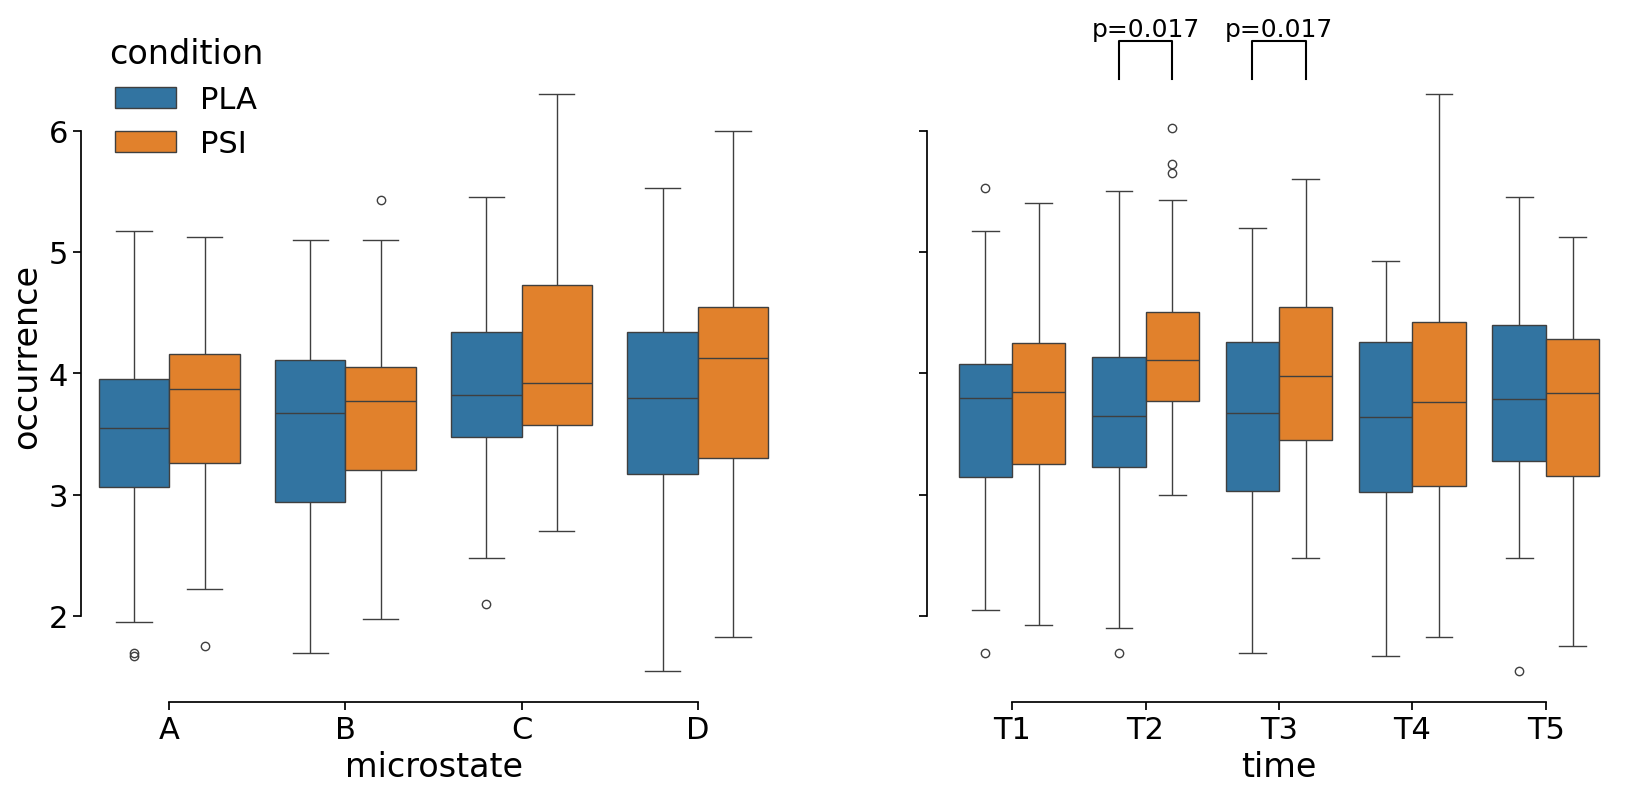

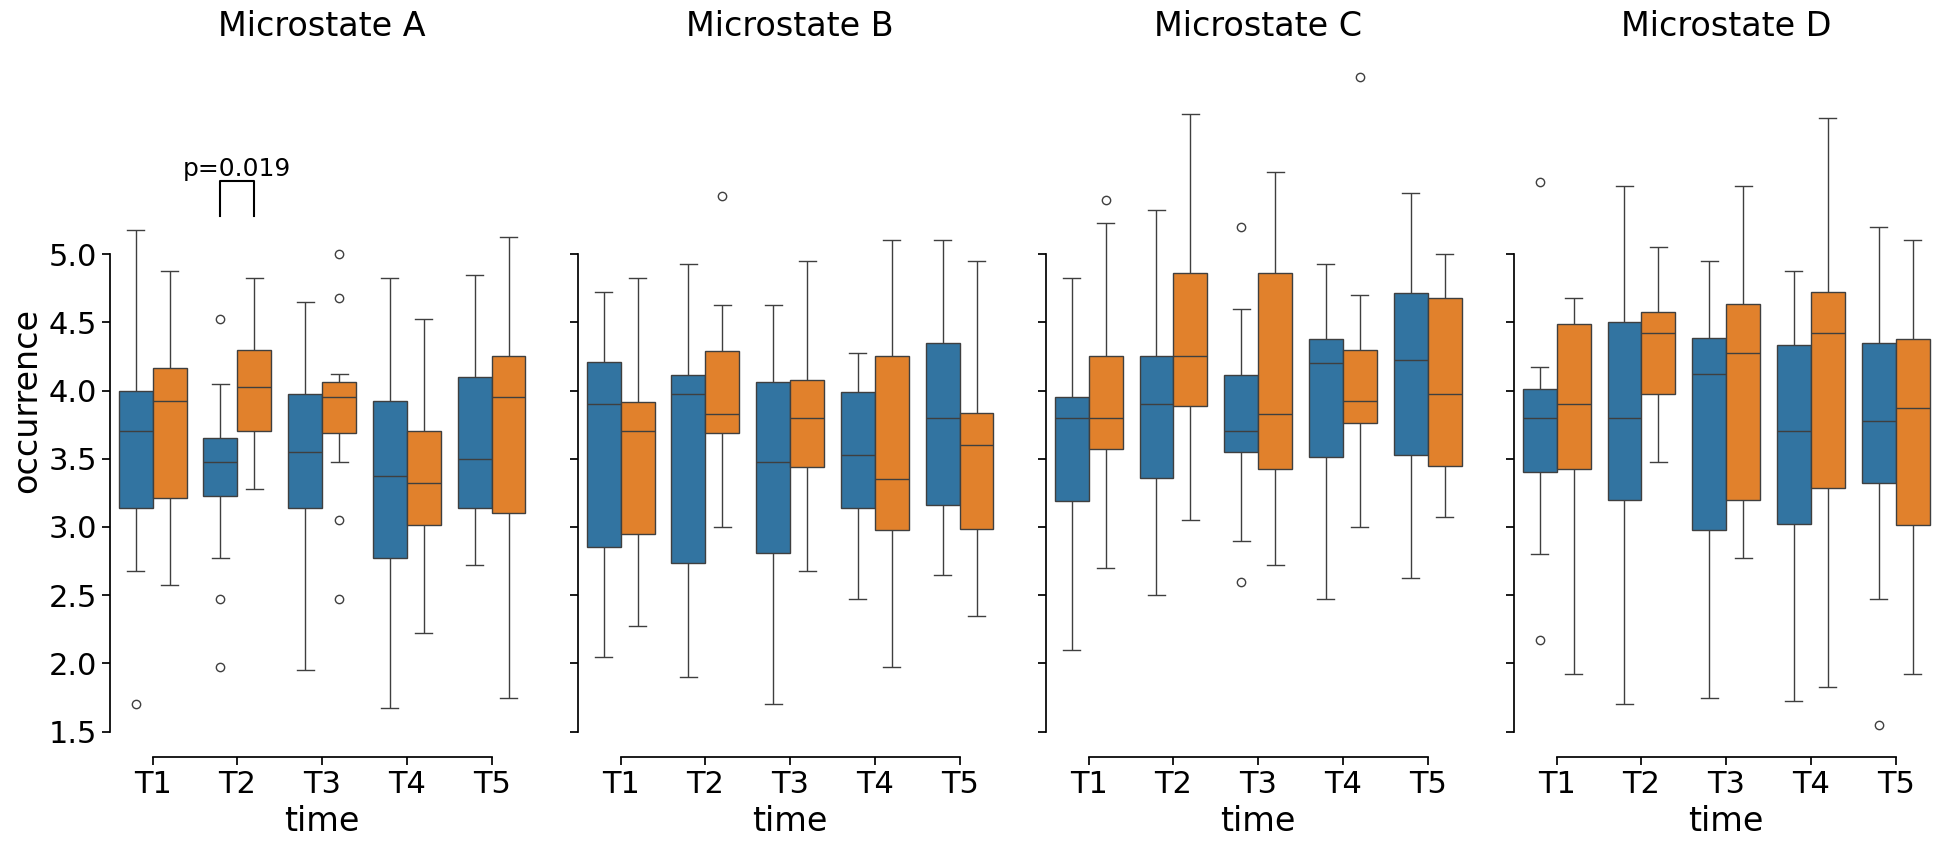

In [15]:
plot_boxes(df_220, "occurrence", "2-20", 1)

### Differences between microstates

In [16]:
diff_between_microstates(df_220, "occurrence", filt_str="2-20")

Microstate differences: occurrence
ANOVA


,Source,ddof1,ddof2,F,p-unc,np2
0,microstate,3,596,8.883936,0.000009,0.042804


Tukey HSD


,A,B,mean(A),mean(B),diff,se,T,p-tukey,cohen
0,A,B,3.608648,3.613647,-0.005000,0.091823,-0.054448,0.999942,-0.006654
1,A,C,3.608648,4.000276,-0.391628,0.091823,-4.265058,0.000136,-0.511355
2,A,D,3.608648,3.864123,-0.255475,0.091823,-2.782270,0.028420,-0.308991
3,B,C,3.613647,4.000276,-0.386629,0.091823,-4.210610,0.000172,-0.507188
4,B,D,3.613647,3.864123,-0.250476,0.091823,-2.727822,0.033145,-0.304158
5,C,D,4.000276,3.864123,0.136153,0.091823,1.482788,0.448552,0.162712


Microstate differences w.r.t condition: occurrence


,Contrast,microstate,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen


### Differences between time

In [17]:
diff_between_time(df_220, "occurrence", filt_str="2-20")

Time differences: occurrence
RM ANOVA


/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,time,1.092366,4,56,0.273091,4.717428,0.002371,0.006660,0.025940,0.736514
1,condition,1.587180,1,14,1.587180,6.302776,0.024953,0.024953,0.037252,1.000000
2,time * condition,1.830420,4,56,0.457605,4.672501,0.002520,0.006493,0.042717,0.754992


Pairwise 'time x condition' t-tests (showing only significant after FDR_BH correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen
0,time,-,T1,T2,3.694431,0.413943,3.921909,0.411027,True,True,-4.514186,14.0,two-sided,0.000486,0.004858,fdr_bh,72.12,-0.551478
5,time,-,T2,T4,3.921909,0.411027,3.683599,0.563148,True,True,3.068050,14.0,two-sided,0.008345,0.041727,fdr_bh,6.465,0.483398
12,time * condition,T2,PLA,PSI,3.661309,0.643622,4.182508,0.357048,True,True,-3.161425,14.0,two-sided,0.006932,0.017331,fdr_bh,7.538,-1.001443
13,time * condition,T3,PLA,PSI,3.586733,0.600947,3.968779,0.442955,True,True,-3.174297,14.0,two-sided,0.006757,0.017331,fdr_bh,7.7,-0.723716


Pairwise 'condition x time' t-tests (showing only significant after FDR_BH correction < 0.05)


,Contrast,condition,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen
1,time,-,T1,T2,3.694431,0.413943,3.921909,0.411027,True,True,-4.514186,14.0,two-sided,0.000486,0.004858,fdr_bh,72.12,-0.551478
6,time,-,T2,T4,3.921909,0.411027,3.683599,0.563148,True,True,3.068050,14.0,two-sided,0.008345,0.041727,fdr_bh,6.465,0.483398
19,condition * time,PLA,T3,T5,3.586733,0.600947,3.829209,0.539212,True,True,-3.901011,14.0,two-sided,0.001599,0.015986,fdr_bh,25.915,-0.424716
20,condition * time,PLA,T4,T5,3.605898,0.552027,3.829209,0.539212,True,True,-3.219416,14.0,two-sided,0.006177,0.034491,fdr_bh,8.296,-0.409252
21,condition * time,PSI,T1,T2,3.727969,0.506773,4.182508,0.357048,True,True,-4.115487,14.0,two-sided,0.001050,0.015986,fdr_bh,37.124,-1.036931
27,condition * time,PSI,T2,T5,4.182508,0.357048,3.732136,0.581098,True,True,3.163914,14.0,two-sided,0.006898,0.034491,fdr_bh,7.569,0.933870


### Significance of time / condition for each microstate

In [18]:
diff_between_time_and_microstates(df_220, "occurrence", filt_str="2-20")

Time differences: occurrence
----------
microstate A
----------
RM ANOVA


/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,time,2.825715,4,56,0.706429,2.208239,0.079718,0.103726,0.034860,0.724890
1,condition,2.029620,1,14,2.029620,2.936131,0.108663,0.108663,0.025287,1.000000
2,time * condition,1.834625,4,56,0.458656,1.094613,0.368196,0.364613,0.022913,0.835015


Pairwise 'time x condition' t-tests (showing only significant after FDR_BH correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen
12,time * condition,T2,PLA,PSI,3.398001,0.629597,3.986277,0.448651,True,True,-3.459834,14.0,two-sided,0.003829,0.019145,fdr_bh,12.373,-1.076122


Pairwise 'condition x time' t-tests (showing only significant after FDR_BH correction < 0.05)


,Contrast,condition,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen


----------
microstate B
----------
RM ANOVA


/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,time,1.101552,4,56,0.275388,0.875884,0.484270,0.452896,0.013748,0.676881
1,condition,0.321954,1,14,0.321954,0.608883,0.448202,0.448202,0.004058,1.000000
2,time * condition,2.855676,4,56,0.713919,1.777941,0.146139,0.162424,0.034878,0.793354


Pairwise 'time x condition' t-tests (showing only significant after FDR_BH correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen


Pairwise 'condition x time' t-tests (showing only significant after FDR_BH correction < 0.05)


,Contrast,condition,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen


----------
microstate C
----------
RM ANOVA


/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,time,2.393091,4,56,0.598273,1.738777,0.154340,0.166538,0.028093,0.839478
1,condition,2.123735,1,14,2.123735,2.968585,0.106901,0.106901,0.025010,1.000000
2,time * condition,2.559142,4,56,0.639785,1.323521,0.272502,0.277626,0.029984,0.824350


Pairwise 'time x condition' t-tests (showing only significant after FDR_BH correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen


Pairwise 'condition x time' t-tests (showing only significant after FDR_BH correction < 0.05)


,Contrast,condition,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen


----------
microstate D
----------
RM ANOVA


/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,time,2.241171,4,56,0.560293,1.822563,0.137305,0.160420,0.019648,0.719278
1,condition,2.528010,1,14,2.528010,3.374896,0.087514,0.087514,0.022107,1.000000
2,time * condition,2.197962,4,56,0.549491,2.129361,0.089141,0.115110,0.019277,0.706889


Pairwise 'time x condition' t-tests (showing only significant after FDR_BH correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen


Pairwise 'condition x time' t-tests (showing only significant after FDR_BH correction < 0.05)


,Contrast,condition,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen


## Average lifespan ~ 1-40Hz filter ~ 3 microstates

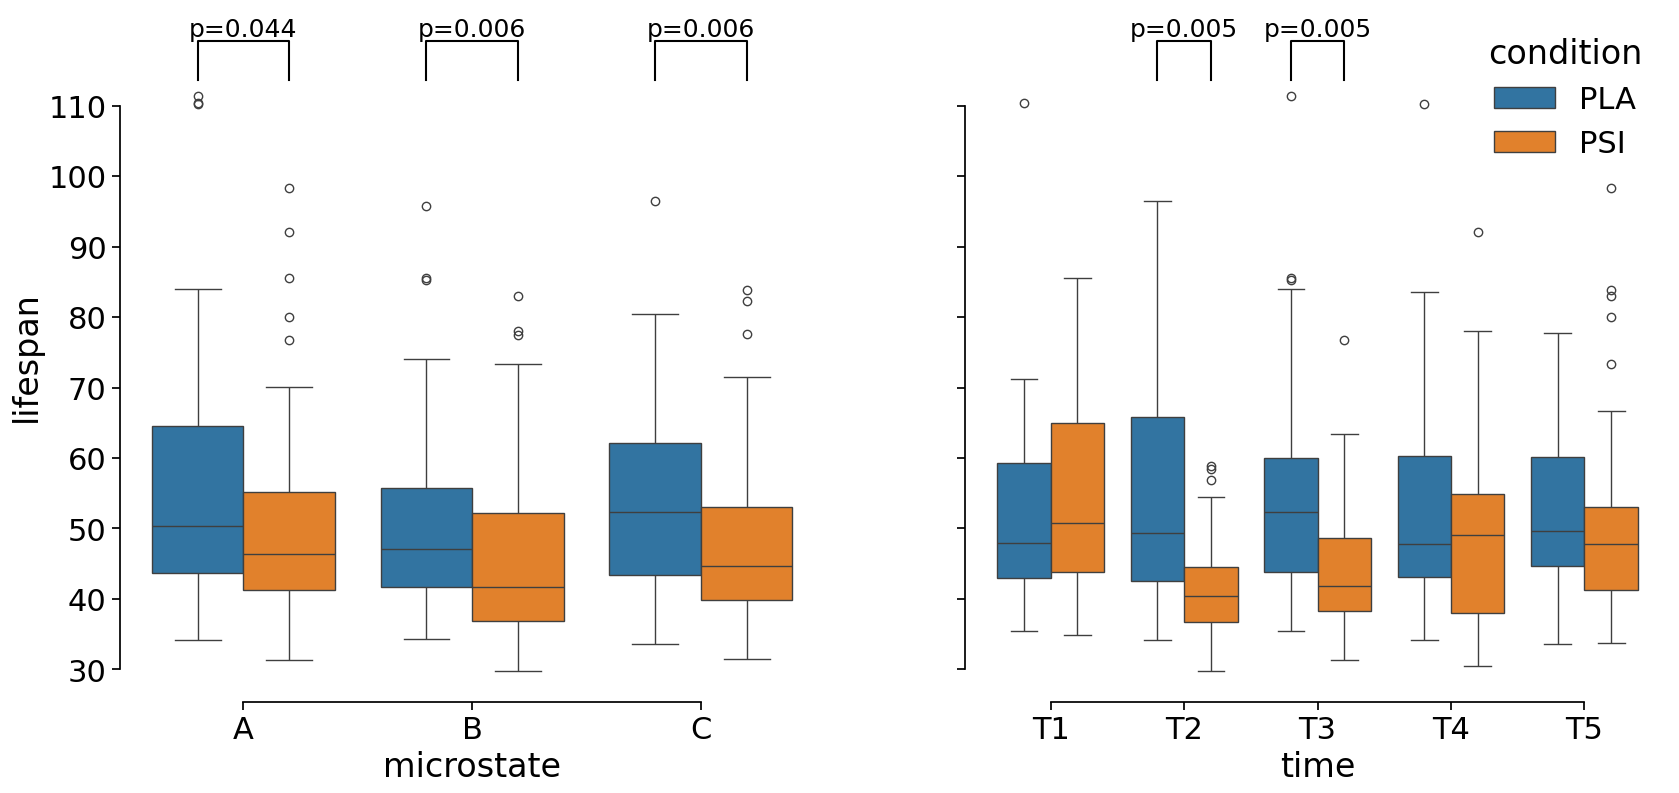

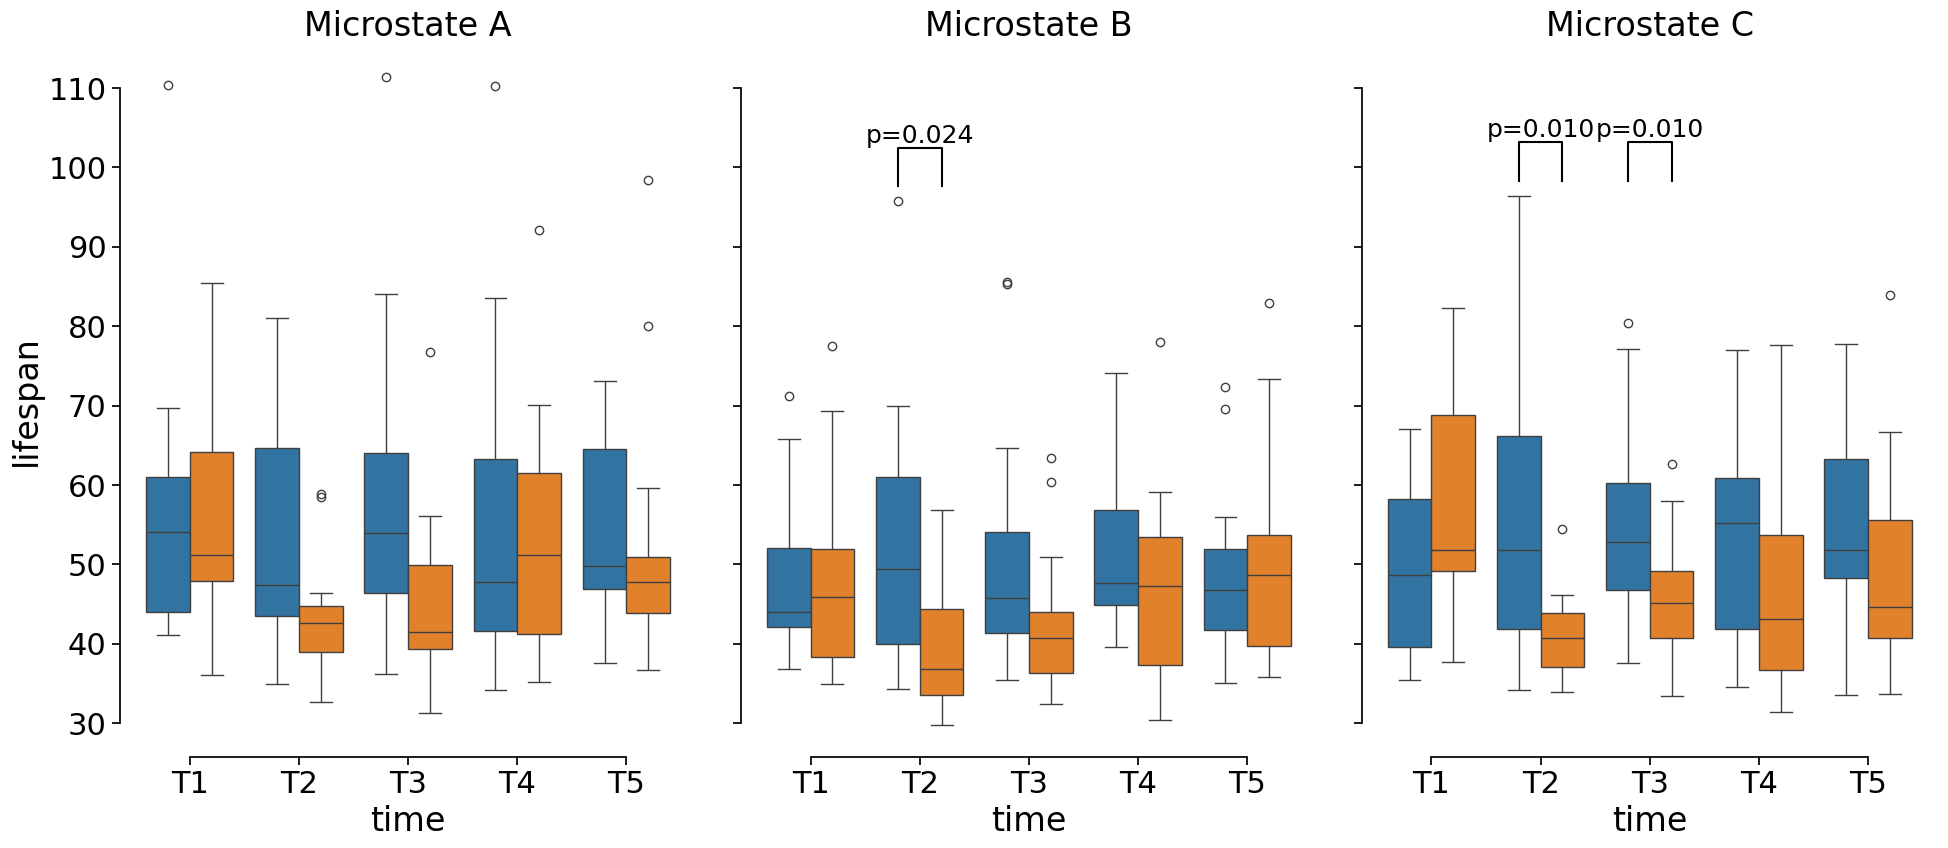

In [19]:
plot_boxes(df_140, "lifespan", "1-40", 2)

### Differences between microstates

In [20]:
diff_between_microstates(df_140, "lifespan", filt_str="1-40")

Microstate differences: lifespan
ANOVA


,Source,ddof1,ddof2,F,p-unc,np2
0,microstate,2,447,4.598961,0.010543,0.020162


Tukey HSD


,A,B,mean(A),mean(B),diff,se,T,p-tukey,cohen
0,A,B,52.852796,48.055845,4.796951,1.592206,3.012771,0.007693,0.337939
1,A,C,52.852796,50.934238,1.918557,1.592206,1.204968,0.450830,0.133716
2,B,C,48.055845,50.934238,-2.878394,1.592206,-1.807802,0.168165,-0.225420


Microstate differences w.r.t condition: lifespan


,Contrast,microstate,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen
4,microstate * condition,A,PLA,PSI,True,True,2.209131,14.0,two-sided,0.044335,0.044335,fdr_bh,1.687,0.488522
5,microstate * condition,B,PLA,PSI,True,True,3.406094,14.0,two-sided,0.004261,0.006391,fdr_bh,11.311,0.489329
6,microstate * condition,C,PLA,PSI,True,True,3.787412,14.0,two-sided,0.002000,0.006000,fdr_bh,21.417,0.570321


### Differences between time

In [21]:
diff_between_time(df_140, "lifespan", filt_str="1-40")

Time differences: lifespan
RM ANOVA


/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,time,455.179649,4,56,113.794912,5.609326,0.000720,0.005377,0.026548,0.599314
1,condition,1125.595185,1,14,1125.595185,13.494683,0.002505,0.002505,0.063179,1.000000
2,time * condition,1095.250510,4,56,273.812627,7.605291,0.000057,0.001127,0.061580,0.595399


Pairwise 'time x condition' t-tests (showing only significant after FDR_BH correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen
0,time,-,T1,T2,52.670895,9.553117,47.721670,8.152713,True,True,4.758546,14.0,two-sided,0.000305,0.003055,fdr_bh,107.878,0.557310
12,time * condition,T2,PLA,PSI,53.987742,13.285024,41.455599,6.365837,True,True,3.742861,14.0,two-sided,0.002184,0.005460,fdr_bh,19.875,1.203081
13,time * condition,T3,PLA,PSI,55.005262,13.355225,44.322077,7.835559,True,True,3.907974,14.0,two-sided,0.001577,0.005460,fdr_bh,26.219,0.975729


Pairwise 'condition x time' t-tests (showing only significant after FDR_BH correction < 0.05)


,Contrast,condition,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen
1,time,-,T1,T2,52.670895,9.553117,47.721670,8.152713,True,True,4.758546,14.0,two-sided,0.000305,0.003055,fdr_bh,107.878,0.557310
21,condition * time,PSI,T1,T2,53.584307,10.587155,41.455599,6.365837,True,True,4.632344,14.0,two-sided,0.000388,0.003879,fdr_bh,87.665,1.388467
22,condition * time,PSI,T1,T3,53.584307,10.587155,44.322077,7.835559,True,True,6.949186,14.0,two-sided,0.000007,0.000135,fdr_bh,3128.326,0.994491
23,condition * time,PSI,T1,T4,53.584307,10.587155,49.144207,12.180400,True,True,3.535792,14.0,two-sided,0.003293,0.021950,fdr_bh,14.048,0.389086


### Significance of time / condition for each microstate

In [22]:
diff_between_time_and_microstates(df_140, "lifespan", filt_str="1-40")

Time differences: lifespan
----------
microstate A
----------
RM ANOVA


/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,time,968.714679,4,56,242.178670,2.468219,0.055106,0.081306,0.028396,0.687698
1,condition,1366.135653,1,14,1366.135653,4.880259,0.044335,0.044335,0.039584,1.000000
2,time * condition,920.567688,4,56,230.141922,2.051984,0.099445,0.141812,0.027022,0.549908


Pairwise 'time x condition' t-tests (showing only significant after FDR_BH correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen


Pairwise 'condition x time' t-tests (showing only significant after FDR_BH correction < 0.05)


,Contrast,condition,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen


----------
microstate B
----------
RM ANOVA


/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,time,284.712785,4,56,71.178196,1.260330,0.296448,0.300719,0.013100,0.665069
1,condition,880.833067,1,14,880.833067,11.601478,0.004261,0.004261,0.039446,1.000000
2,time * condition,1027.227047,4,56,256.806762,3.158496,0.020670,0.031844,0.045702,0.787910


Pairwise 'time x condition' t-tests (showing only significant after FDR_BH correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen
12,time * condition,T2,PLA,PSI,52.376246,16.532384,39.957185,8.85368,True,True,3.353217,14.0,two-sided,0.004734,0.023668,fdr_bh,10.358,0.936511


Pairwise 'condition x time' t-tests (showing only significant after FDR_BH correction < 0.05)


,Contrast,condition,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen


----------
microstate C
----------
RM ANOVA


/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,time,463.614124,4,56,115.903531,1.706250,0.161483,0.169154,0.021142,0.895345
1,condition,1156.650759,1,14,1156.650759,14.344491,0.002000,0.002000,0.051131,1.000000
2,time * condition,1861.019091,4,56,465.254773,5.941924,0.000466,0.001557,0.079784,0.775942


Pairwise 'time x condition' t-tests (showing only significant after FDR_BH correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen
12,time * condition,T2,PLA,PSI,55.638441,16.445902,40.935440,5.365445,True,True,3.729058,14.0,two-sided,0.002244,0.010385,fdr_bh,19.42,1.201987
13,time * condition,T3,PLA,PSI,55.487158,12.327727,45.697105,8.048407,True,True,3.418888,14.0,two-sided,0.004154,0.010385,fdr_bh,11.555,0.940418


Pairwise 'condition x time' t-tests (showing only significant after FDR_BH correction < 0.05)


,Contrast,condition,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen
21,condition * time,PSI,T1,T2,56.592227,13.118788,40.935440,5.365445,True,True,4.844292,14.0,two-sided,0.000260,0.005026,fdr_bh,124.128,1.562204
22,condition * time,PSI,T1,T3,56.592227,13.118788,45.697105,8.048407,True,True,4.496402,14.0,two-sided,0.000503,0.005026,fdr_bh,70.026,1.001114
23,condition * time,PSI,T1,T4,56.592227,13.118788,47.548024,13.688979,True,True,4.117221,14.0,two-sided,0.001046,0.006976,fdr_bh,37.232,0.674592


## Coverage ~ 1-40Hz filter ~ 3 microstates

/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/parametric.py:248: UserWarning: x and y are equals. Cannot compute T or p-value.
  warnings.warn("x and y are equals. Cannot compute T or p-value.")
/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/parametric.py:248: UserWarning: x and y are equals. Cannot compute T or p-value.
  warnings.warn("x and y are equals. Cannot compute T or p-value.")


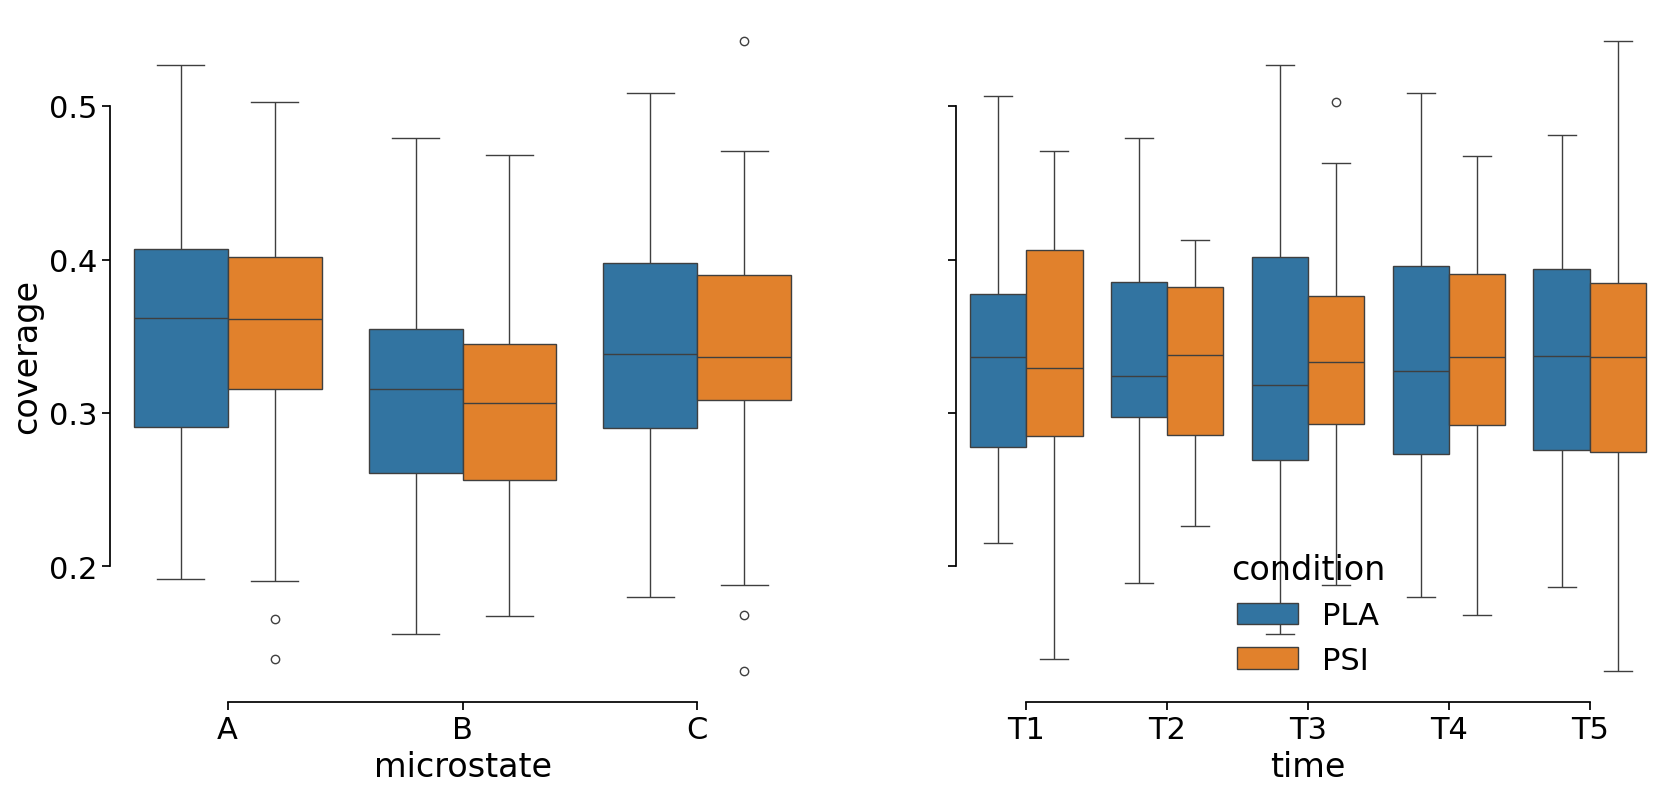

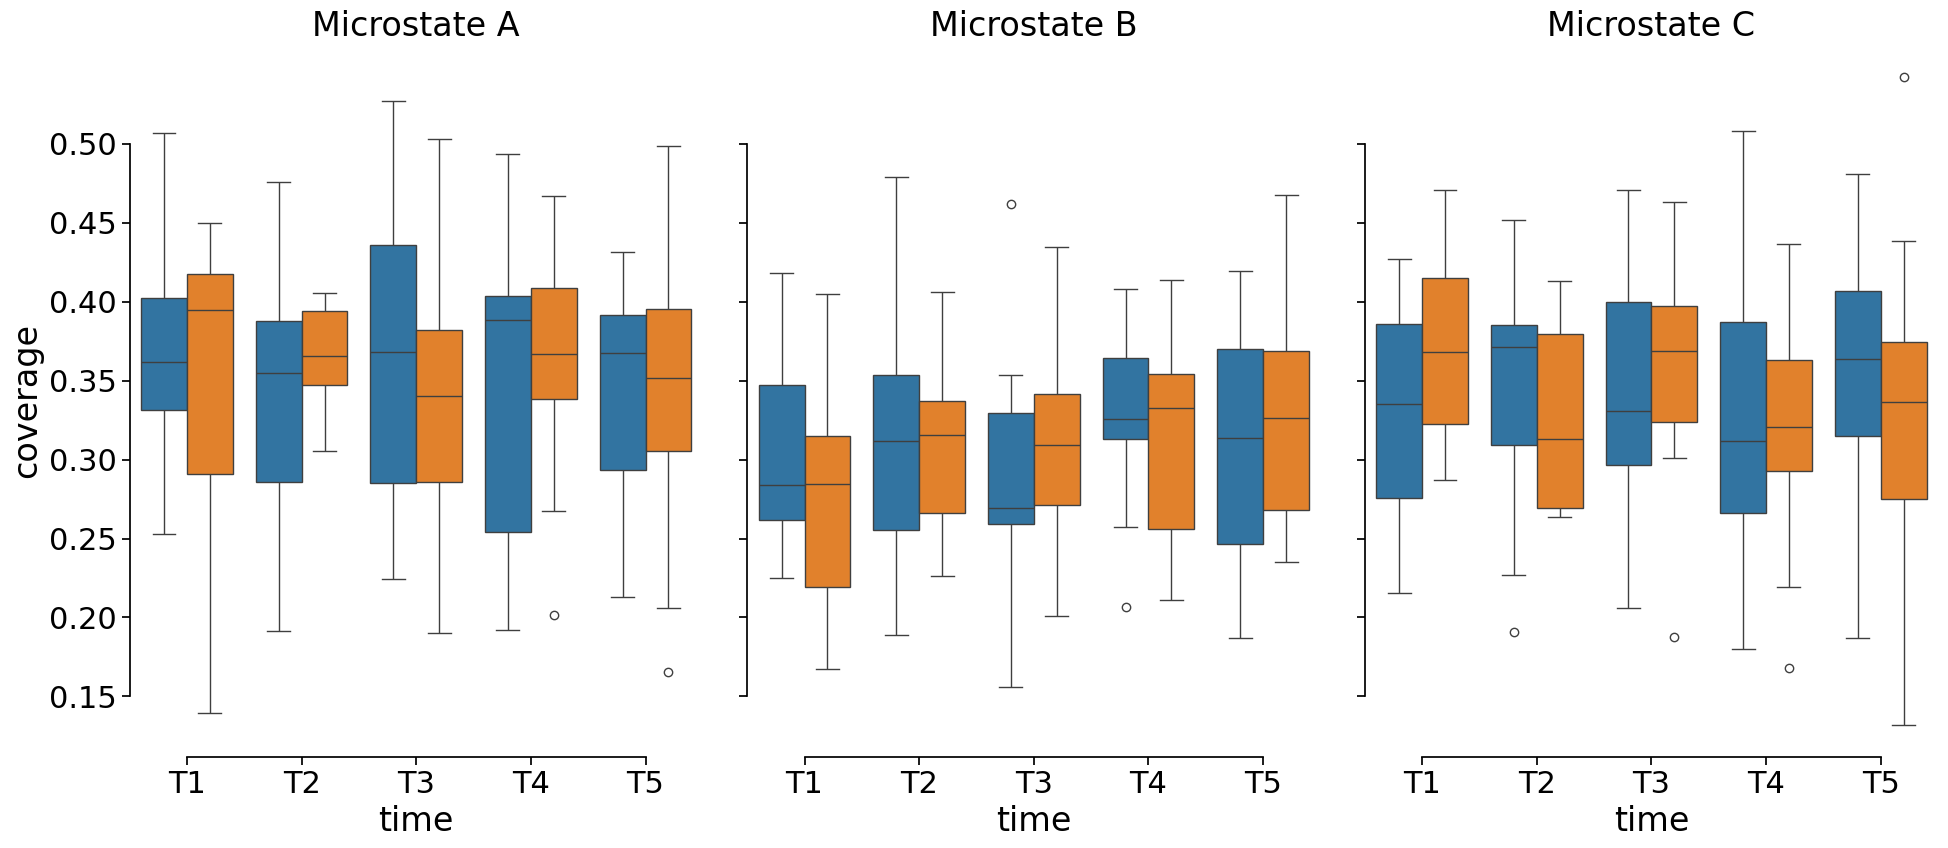

In [23]:
plot_boxes(df_140, "coverage", "1-40", 2)

### Differences between microstates

In [24]:
diff_between_microstates(df_140, "coverage", filt_str="1-40")

Microstate differences: coverage
ANOVA


,Source,ddof1,ddof2,F,p-unc,np2
0,microstate,2,447,13.615467,0.000002,0.057421


Tukey HSD


,A,B,mean(A),mean(B),diff,se,T,p-tukey,cohen
0,A,B,0.350325,0.308333,0.041991,0.008475,4.954952,0.000003,0.579455
1,A,C,0.350325,0.341342,0.008982,0.008475,1.059893,0.539537,0.117368
2,B,C,0.308333,0.341342,-0.033009,0.008475,-3.895058,0.000333,-0.464455


Microstate differences w.r.t condition: coverage


,Contrast,microstate,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen
0,microstate,-,A,B,False,True,3.424233,28.0,two-sided,0.001919,0.005233,fdr_bh,18.296,1.250353
2,microstate,-,B,C,False,True,-3.190453,28.0,two-sided,0.003488,0.005233,fdr_bh,11.413,-1.164989


### Differences between time

In [25]:
diff_between_time(df_140, "coverage", filt_str="1-40")

Time differences: coverage
RM ANOVA


/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,time,4.622232e-31,4,56,1.155558e-31,-12.352941,1.0,1.0,1.079137,0.798030
1,condition,4.622232e-31,1,14,4.622232e-31,-14.000000,1.0,1.0,1.079137,1.000000
2,time * condition,-4.622232e-31,4,56,-1.155558e-31,-13.207547,1.0,1.0,0.931677,0.657306


Pairwise 'time x condition' t-tests (showing only significant after FDR_BH correction < 0.05)


/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/parametric.py:248: UserWarning: x and y are equals. Cannot compute T or p-value.
  warnings.warn("x and y are equals. Cannot compute T or p-value.")
/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/parametric.py:248: UserWarning: x and y are equals. Cannot compute T or p-value.
  warnings.warn("x and y are equals. Cannot compute T or p-value.")


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen


Pairwise 'condition x time' t-tests (showing only significant after FDR_BH correction < 0.05)


/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/parametric.py:248: UserWarning: x and y are equals. Cannot compute T or p-value.
  warnings.warn("x and y are equals. Cannot compute T or p-value.")
/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/parametric.py:248: UserWarning: x and y are equals. Cannot compute T or p-value.
  warnings.warn("x and y are equals. Cannot compute T or p-value.")
/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/parametric.py:248: UserWarning: x and y are equals. Cannot compute T or p-value.
  warnings.warn("x and y are equals. Cannot compute T or p-value.")


,Contrast,condition,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen


### Significance of time / condition for each microstate

In [26]:
diff_between_time_and_microstates(df_140, "coverage", filt_str="1-40")

Time differences: coverage
----------
microstate A
----------
RM ANOVA


/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,time,0.005406,4,56,0.001351,0.230914,0.919879,0.869980,0.006147,0.731735
1,condition,0.000180,1,14,0.000180,0.028977,0.867268,0.867268,0.000206,1.000000
2,time * condition,0.022999,4,56,0.005750,1.124558,0.354231,0.344316,0.025642,0.591890


Pairwise 'time x condition' t-tests (showing only significant after FDR_BH correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen


Pairwise 'condition x time' t-tests (showing only significant after FDR_BH correction < 0.05)


,Contrast,condition,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen


----------
microstate B
----------
RM ANOVA


/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,time,0.020486,4,56,0.005122,1.489002,0.217850,0.225979,0.031671,0.850508
1,condition,0.000626,1,14,0.000626,0.238395,0.632926,0.632926,0.000998,1.000000
2,time * condition,0.014949,4,56,0.003737,0.823789,0.515574,0.483557,0.023311,0.714728


Pairwise 'time x condition' t-tests (showing only significant after FDR_BH correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen


Pairwise 'condition x time' t-tests (showing only significant after FDR_BH correction < 0.05)


,Contrast,condition,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen


----------
microstate C
----------
RM ANOVA


/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,time,0.015564,4,56,0.003891,0.675238,0.611957,0.597645,0.019013,0.902609
1,condition,0.000135,1,14,0.000135,0.018835,0.892795,0.892795,0.000168,1.000000
2,time * condition,0.024055,4,56,0.006014,1.128400,0.352472,0.348816,0.029083,0.762623


Pairwise 'time x condition' t-tests (showing only significant after FDR_BH correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen


Pairwise 'condition x time' t-tests (showing only significant after FDR_BH correction < 0.05)


,Contrast,condition,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen


## Frequency of occurrence ~ 1-40Hz filter ~ 3 microstates

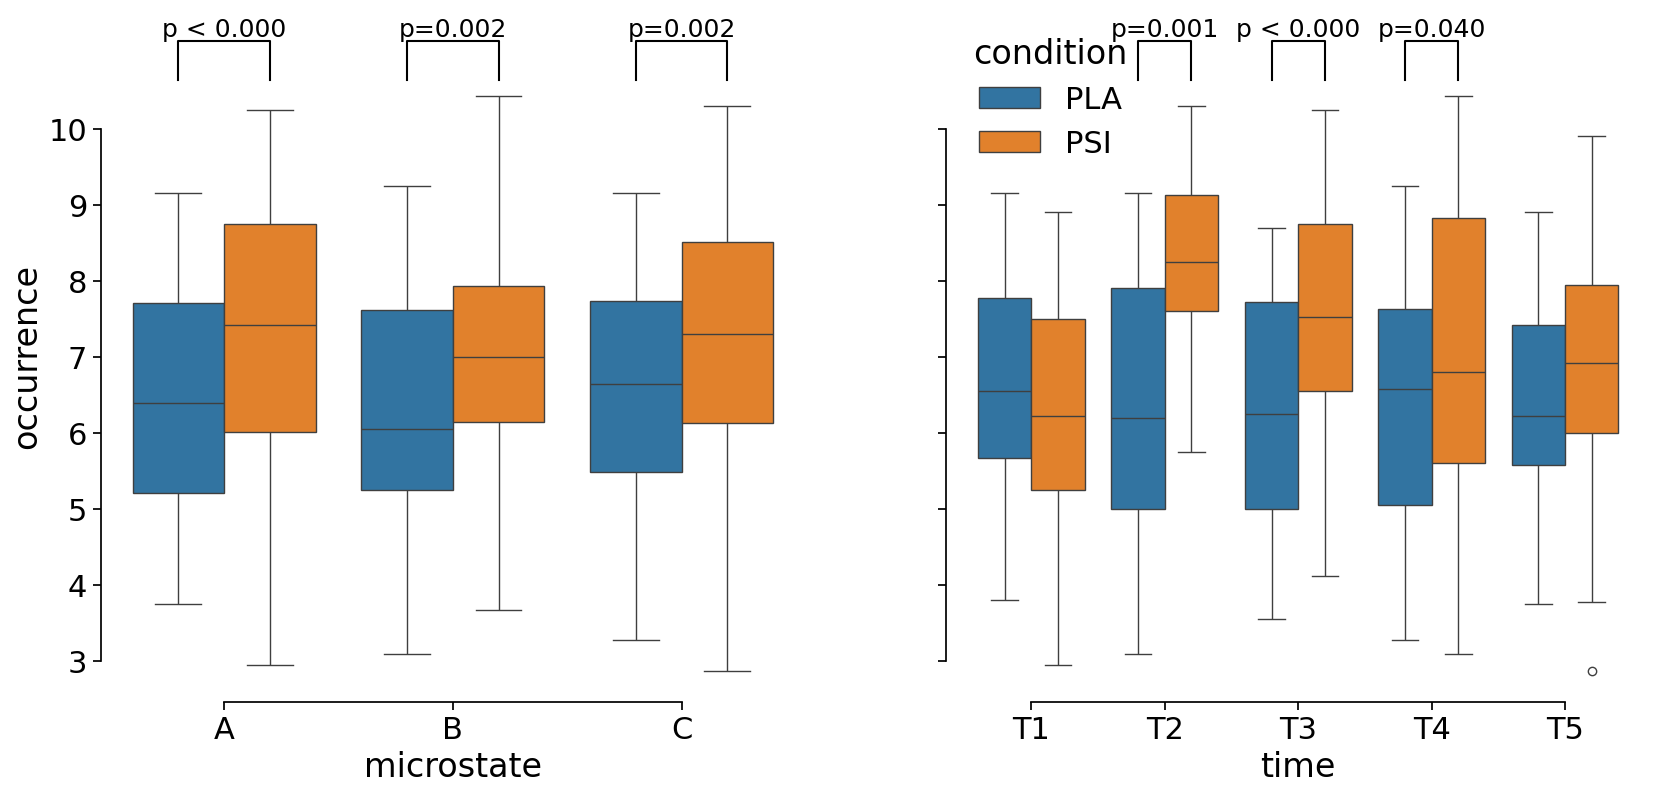

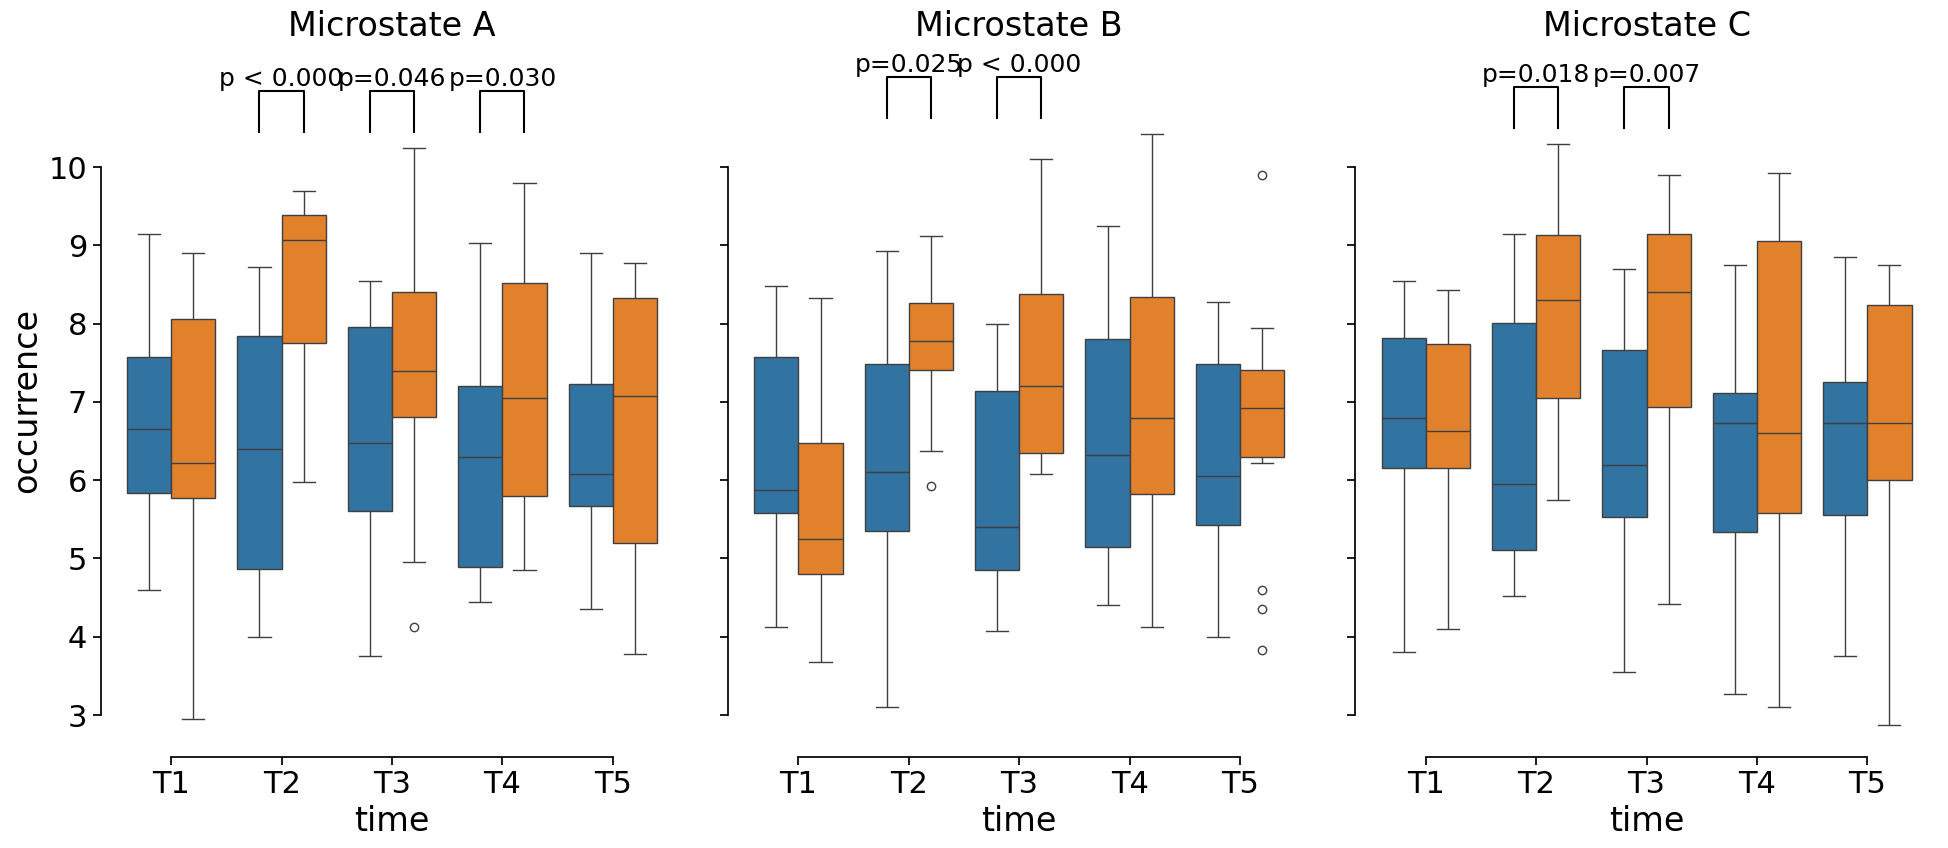

In [27]:
plot_boxes(df_140, "occurrence", "1-40", 2)

### Differences between microstates

In [28]:
diff_between_microstates(df_140, "occurrence", filt_str="1-40")

Microstate differences: occurrence
ANOVA


,Source,ddof1,ddof2,F,p-unc,np2
0,microstate,2,447,1.444386,0.23699,0.006421


Tukey HSD


,A,B,mean(A),mean(B),diff,se,T,p-tukey,cohen
0,A,B,6.877995,6.622020,0.255975,0.184545,1.387063,0.348531,0.161165
1,A,C,6.877995,6.906992,-0.028997,0.184545,-0.157128,0.986481,-0.017754
2,B,C,6.622020,6.906992,-0.284972,0.184545,-1.544191,0.271328,-0.181225


Microstate differences w.r.t condition: occurrence


,Contrast,microstate,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen
4,microstate * condition,A,PLA,PSI,True,True,-5.491740,14.0,two-sided,0.000079,0.000238,fdr_bh,351.076,-0.607513
5,microstate * condition,B,PLA,PSI,True,True,-3.807568,14.0,two-sided,0.001922,0.001922,fdr_bh,22.154,-0.523448
6,microstate * condition,C,PLA,PSI,True,True,-4.032772,14.0,two-sided,0.001234,0.001851,fdr_bh,32.322,-0.642841


### Differences between time

In [29]:
diff_between_time(df_140, "occurrence", filt_str="1-40")

Time differences: occurrence
RM ANOVA


/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,time,12.499861,4,56,3.124965,8.255004,0.000026,0.001281,0.046523,0.520693
1,condition,20.890144,1,14,20.890144,30.249219,0.000078,0.000078,0.075396,1.000000
2,time * condition,19.553739,4,56,4.888435,9.456481,0.000007,0.000157,0.070915,0.660840


Pairwise 'time x condition' t-tests (showing only significant after FDR_BH correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen
0,time,-,T1,T2,6.459091,1.151931,7.275956,1.091998,True,True,-5.186443,14.0,two-sided,0.000138,0.001380,fdr_bh,216.02,-0.727807
1,time,-,T1,T3,6.459091,1.151931,6.945988,1.238716,True,True,-4.114245,14.0,two-sided,0.001052,0.005262,fdr_bh,37.047,-0.407067
6,time,-,T2,T5,7.275956,1.091998,6.574913,1.238798,True,True,3.370271,14.0,two-sided,0.004576,0.015252,fdr_bh,10.656,0.600358
12,time * condition,T2,PLA,PSI,6.422706,1.534701,8.129206,1.070910,True,True,-4.421453,14.0,two-sided,0.000580,0.001451,fdr_bh,61.84,-1.289596
13,time * condition,T3,PLA,PSI,6.257722,1.348993,7.634254,1.320608,True,True,-5.358394,14.0,two-sided,0.000101,0.000505,fdr_bh,284.282,-1.031206
14,time * condition,T4,PLA,PSI,6.431594,1.359478,7.079864,1.733607,True,True,-2.536115,14.0,two-sided,0.023748,0.039580,fdr_bh,2.761,-0.416141


Pairwise 'condition x time' t-tests (showing only significant after FDR_BH correction < 0.05)


,Contrast,condition,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen
1,time,-,T1,T2,6.459091,1.151931,7.275956,1.091998,True,True,-5.186443,14.0,two-sided,1.379652e-04,0.001380,fdr_bh,216.02,-0.727807
2,time,-,T1,T3,6.459091,1.151931,6.945988,1.238716,True,True,-4.114245,14.0,two-sided,1.052453e-03,0.005262,fdr_bh,37.047,-0.407067
7,time,-,T2,T5,7.275956,1.091998,6.574913,1.238798,True,True,3.370271,14.0,two-sided,4.575659e-03,0.015252,fdr_bh,10.656,0.600358
21,condition * time,PSI,T1,T2,6.315494,1.207885,8.129206,1.070910,True,True,-5.645408,14.0,two-sided,6.040496e-05,0.000604,fdr_bh,446.775,-1.588949
22,condition * time,PSI,T1,T3,6.315494,1.207885,7.634254,1.320608,True,True,-9.687064,14.0,two-sided,1.382968e-07,0.000003,fdr_bh,1.051e+05,-1.042084
23,condition * time,PSI,T1,T4,6.315494,1.207885,7.079864,1.733607,True,True,-3.444297,14.0,two-sided,3.949174e-03,0.026328,fdr_bh,12.056,-0.511609
27,condition * time,PSI,T2,T5,8.129206,1.070910,6.718788,1.436127,True,True,3.222556,14.0,two-sided,6.138862e-03,0.030694,fdr_bh,8.339,1.113415


### Significance of time / condition for each microstate

In [30]:
diff_between_time_and_microstates(df_140, "occurrence", filt_str="1-40")

Time differences: occurrence
----------
microstate A
----------
RM ANOVA


/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,time,16.490387,4,56,4.122597,6.199291,0.000334,0.001741,0.046219,0.710488
1,condition,24.801822,1,14,24.801822,30.159208,0.000079,0.000079,0.067932,1.000000
2,time * condition,23.303323,4,56,5.825831,6.252936,0.000312,0.001013,0.064090,0.795101


Pairwise 'time x condition' t-tests (showing only significant after FDR_BH correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen
0,time,-,T1,T2,6.581024,1.386430,7.472604,1.264530,True,True,-4.148591,14.0,two-sided,0.000984,0.009843,fdr_bh,39.238,-0.671936
1,time,-,T1,T3,6.581024,1.386430,6.980152,1.421025,True,True,-2.726215,14.0,two-sided,0.016392,0.040981,fdr_bh,3.721,-0.284313
5,time,-,T2,T4,7.472604,1.264530,6.771839,1.516311,True,True,2.905008,14.0,two-sided,0.011527,0.038425,fdr_bh,4.957,0.501942
6,time,-,T2,T5,7.472604,1.264530,6.584357,1.427992,True,True,3.062615,14.0,two-sided,0.008436,0.038425,fdr_bh,6.408,0.658575
12,time * condition,T2,PLA,PSI,6.409374,1.704051,8.535833,1.179733,True,True,-5.558893,14.0,two-sided,0.000070,0.000352,fdr_bh,390.188,-1.450982
13,time * condition,T3,PLA,PSI,6.504365,1.573037,7.455939,1.639158,True,True,-2.459513,14.0,two-sided,0.027535,0.045892,fdr_bh,2.454,-0.592350
14,time * condition,T4,PLA,PSI,6.311050,1.499760,7.232627,1.763997,True,True,-2.890166,14.0,two-sided,0.011870,0.029676,fdr_bh,4.839,-0.562892


Pairwise 'condition x time' t-tests (showing only significant after FDR_BH correction < 0.05)


,Contrast,condition,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen
1,time,-,T1,T2,6.581024,1.386430,7.472604,1.264530,True,True,-4.148591,14.0,two-sided,0.000984,0.009843,fdr_bh,39.238,-0.671936
2,time,-,T1,T3,6.581024,1.386430,6.980152,1.421025,True,True,-2.726215,14.0,two-sided,0.016392,0.040981,fdr_bh,3.721,-0.284313
6,time,-,T2,T4,7.472604,1.264530,6.771839,1.516311,True,True,2.905008,14.0,two-sided,0.011527,0.038425,fdr_bh,4.957,0.501942
7,time,-,T2,T5,7.472604,1.264530,6.584357,1.427992,True,True,3.062615,14.0,two-sided,0.008436,0.038425,fdr_bh,6.408,0.658575
21,condition * time,PSI,T1,T2,6.467702,1.730115,8.535833,1.179733,True,True,-4.674554,14.0,two-sided,0.000358,0.007161,fdr_bh,93.976,-1.396706
22,condition * time,PSI,T1,T3,6.467702,1.730115,7.455939,1.639158,True,True,-3.612344,14.0,two-sided,0.002828,0.018856,fdr_bh,15.969,-0.586404
23,condition * time,PSI,T1,T4,6.467702,1.730115,7.232627,1.763997,True,True,-3.050168,14.0,two-sided,0.008647,0.043235,fdr_bh,6.278,-0.437816
26,condition * time,PSI,T2,T4,8.535833,1.179733,7.232627,1.763997,True,True,2.901723,14.0,two-sided,0.011602,0.046410,fdr_bh,4.931,0.868471
27,condition * time,PSI,T2,T5,8.535833,1.179733,6.731009,1.708254,True,True,3.713418,14.0,two-sided,0.002315,0.018856,fdr_bh,18.917,1.229465


----------
microstate B
----------
RM ANOVA


/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,time,15.350643,4,56,3.837661,5.372367,0.000985,0.004257,0.050141,0.689634
1,condition,14.012080,1,14,14.012080,14.497577,0.001922,0.001922,0.045970,1.000000
2,time * condition,26.688179,4,56,6.672045,6.240108,0.000317,0.001713,0.084061,0.706616


Pairwise 'time x condition' t-tests (showing only significant after FDR_BH correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen
0,time,-,T1,T2,6.067741,1.106254,7.007649,0.931338,True,True,-4.522982,14.0,two-sided,0.000478,0.004777,fdr_bh,73.177,-0.919187
2,time,-,T1,T4,6.067741,1.106254,6.811835,1.546187,True,True,-3.543671,14.0,two-sided,0.003241,0.016207,fdr_bh,14.234,-0.553502
6,time,-,T2,T5,7.007649,0.931338,6.512697,1.267339,True,True,2.915294,14.0,two-sided,0.011295,0.037651,fdr_bh,5.04,0.445060
12,time * condition,T2,PLA,PSI,6.281053,1.674342,7.734245,0.854411,True,True,-2.967419,14.0,two-sided,0.010188,0.025471,fdr_bh,5.485,-1.093299
13,time * condition,T3,PLA,PSI,5.927754,1.430515,7.492602,1.319756,True,True,-6.488727,14.0,two-sided,0.000014,0.000071,fdr_bh,1606.202,-1.137037


Pairwise 'condition x time' t-tests (showing only significant after FDR_BH correction < 0.05)


,Contrast,condition,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen
1,time,-,T1,T2,6.067741,1.106254,7.007649,0.931338,True,True,-4.522982,14.0,two-sided,0.000478,0.004777,fdr_bh,73.177,-0.919187
3,time,-,T1,T4,6.067741,1.106254,6.811835,1.546187,True,True,-3.543671,14.0,two-sided,0.003241,0.016207,fdr_bh,14.234,-0.553502
7,time,-,T2,T5,7.007649,0.931338,6.512697,1.267339,True,True,2.915294,14.0,two-sided,0.011295,0.037651,fdr_bh,5.04,0.445060
18,condition * time,PLA,T3,T4,5.927754,1.430515,6.606022,1.602783,True,True,-3.967516,14.0,two-sided,0.001403,0.009351,fdr_bh,28.973,-0.446495
21,condition * time,PSI,T1,T2,5.694444,1.269620,7.734245,0.854411,True,True,-5.924669,14.0,two-sided,0.000037,0.000741,fdr_bh,688.167,-1.885010
22,condition * time,PSI,T1,T3,5.694444,1.269620,7.492602,1.319756,True,True,-4.958874,14.0,two-sided,0.000210,0.002100,fdr_bh,149.596,-1.388613
23,condition * time,PSI,T1,T4,5.694444,1.269620,7.017648,1.844006,True,True,-3.760500,14.0,two-sided,0.002109,0.010546,fdr_bh,20.472,-0.835841


----------
microstate C
----------
RM ANOVA


/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,time,12.356062,4,56,3.089015,3.054659,0.023945,0.042156,0.035352,0.705717
1,condition,24.883206,1,14,24.883206,16.263249,0.001234,0.001234,0.068729,1.000000
2,time * condition,15.606843,4,56,3.901711,3.920413,0.007090,0.016666,0.044241,0.711113


Pairwise 'time x condition' t-tests (showing only significant after FDR_BH correction < 0.05)


,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen
12,time * condition,T2,PLA,PSI,6.577691,1.665988,8.117541,1.541024,True,True,-3.130387,14.0,two-sided,0.007374,0.018434,fdr_bh,7.162,-0.959573
13,time * condition,T3,PLA,PSI,6.341047,1.572397,7.954223,1.599319,True,True,-3.952841,14.0,two-sided,0.001444,0.007218,fdr_bh,28.269,-1.017189


Pairwise 'condition x time' t-tests (showing only significant after FDR_BH correction < 0.05)


,Contrast,condition,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen
22,condition * time,PSI,T1,T3,6.784337,1.193983,7.954223,1.599319,True,True,-4.18302,14.0,two-sided,0.00092,0.018409,fdr_bh,41.563,-0.828954
